### Madrid, December, 2024.

# **ASSIGNMENT 1: PREDICTING EMPLOYEE ATTRITION**

## **Authors:**
- Marta Palacios Merinero - 100451470
- Leire Domínguez-Sol Sastre - 100452054
- Leire Pantoja Jiménez - 100452928

The objective of this project is to develop a predictive model to identify employees at risk of resigning, addressing the critical issue of employee attrition. Using a dataset provided by the human resources department, the analysis will involve applying both basic and advanced machine learning techniques. Key tasks will include preprocessing steps such as data imputation, encoding, and handling constant features, as well as managing class imbalance. Additionally, hyperparameter tuning will be performed to optimize the model's performance, ensuring robust and reliable predictions.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install imbalanced-learn
!pip install optuna
!pip install optuna.integration


In [ ]:
import pandas as pd
import os
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import sys
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from PIL import Image
import statsmodels.api as sm
import joblib
from sklearn.dummy import DummyClassifier
from time import time
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, CategoricalDistribution
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, make_scorer
from sklearn.preprocessing import LabelEncoder


# **1. Load and exploratory analysis**

In this section, the dataset provided by the human resources department is loaded and examined to gain an initial understanding of its structure and contents. Key steps include inspecting the data types, identifying missing values, and analyzing basic statistical summaries. Exploratory Data Analysis (EDA) is performed to detect patterns, relationships, and potential anomalies in the data.

In [ ]:
# current directory
dir= os.getcwd()
# path to the files
file_path = os.path.join(dir, 'attrition_availabledata_07.csv')
data = pd.read_csv(file_path, sep=",")

# data info
print("Data Summary:")
print(data.info())

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2940 non-null   float64
 1   absences                 2940 non-null   int64  
 2   JobInvolvement           2940 non-null   int64  
 3   PerformanceRating        2940 non-null   int64  
 4   EnvironmentSatisfaction  2920 non-null   float64
 5   JobSatisfaction          2924 non-null   float64
 6   WorkLifeBalance          2916 non-null   float64
 7   Age                      2940 non-null   int64  
 8   BusinessTravel           2940 non-null   object 
 9   Department               2940 non-null   object 
 10  DistanceFromHome         2940 non-null   int64  
 11  Education                2940 non-null   int64  
 12  EducationField           2940 non-null   object 
 13  EmployeeCount            2940 non-null   int64  
 14  EmployeeID

The dataset consists of **2,940 observations** and **31 features**, encompassing a mix of numerical and categorical variables. These features capture various aspects of employee characteristics, workplace conditions, and performance metrics.


In [ ]:
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\n Categorical Features:")
print("-" * 30)
for feature in categorical_features:
    print(f"• {feature}")

print("\n Numerical Features:")
print("-" * 30)
for feature in numerical_features:
    print(f"• {feature}")



 Categorical Features:
------------------------------
• BusinessTravel
• Department
• EducationField
• Gender
• JobRole
• MaritalStatus
• Over18
• Attrition

 Numerical Features:
------------------------------
• hrs
• absences
• JobInvolvement
• PerformanceRating
• EnvironmentSatisfaction
• JobSatisfaction
• WorkLifeBalance
• Age
• DistanceFromHome
• Education
• EmployeeCount
• EmployeeID
• JobLevel
• MonthlyIncome
• NumCompaniesWorked
• PercentSalaryHike
• StandardHours
• StockOptionLevel
• TotalWorkingYears
• TrainingTimesLastYear
• YearsAtCompany
• YearsSinceLastPromotion
• YearsWithCurrManager


The dataset includes **17 numerical features**, such as `hrs`, `absences`, `Age`, `MonthlyIncome`, and `YearsAtCompany`. These variables offer insight into employee demographics, work history, and performance indicators. Notably, some numerical features like `EnvironmentSatisfaction`, `JobSatisfaction`, `WorkLifeBalance`, `NumCompaniesWorked`, and `TotalWorkingYears` contain missing values, indicating the need for imputation during the preprocessing phase.

There are **8 categorical variables**, including `BusinessTravel`, `Department`, `Gender`, `JobRole`, `MaritalStatus`, and `Attrition` (the target variable). These features represent qualitative aspects of employees' roles, personal circumstances, and workplace dynamics. Proper encoding techniques will be necessary to incorporate these features into the machine learning models.

In [ ]:
# identify null values
missing_values = data.isnull().sum()
print("Null values per column:")
print(missing_values[missing_values > 0])

Null values per column:
EnvironmentSatisfaction    20
JobSatisfaction            16
WorkLifeBalance            24
NumCompaniesWorked         15
TotalWorkingYears           7
dtype: int64


The dataset contains missing values in five numerical variables: `EnvironmentSatisfaction`, `JobSatisfaction`, `WorkLifeBalance`, `NumCompaniesWorked`, and `TotalWorkingYears`. The proportion of missing values is relatively low, suggesting that appropriate imputation techniques, such as mean, median, or mode imputation, can be effectively applied without significantly compromising data integrity.

In [ ]:
constant_columns = [col for col in data.columns if data[col].nunique() == 1]

print("\n Constant Columns:")
print("-" * 30)
if constant_columns:
    for col in constant_columns:
        print(f"• {col}")
else:
    print("No constant columns found.")


 Constant Columns:
------------------------------
• EmployeeCount
• Over18
• StandardHours


The dataset contains three constant columns: `EmployeeCount`, `Over18`, and `StandardHours`. These columns have the same value across all rows, meaning they do not provide any variability or useful information for predictive modeling. `EmployeeCount` likely represents a placeholder or static count, `Over18` indicates a binary condition that is true for all employees, and `StandardHours` seems to represent a fixed contractual working hour value. As these features do not contribute to distinguishing patterns in the data, they can be safely removed during the preprocessing stage to improve model efficiency and reduce unnecessary complexity.

In [ ]:
# ID columns
id_columns = [col for col in data.columns if data[col].nunique() == data.shape[0]]
print("\n ID Columns:")
print("-" * 30)
if id_columns:
    for col in id_columns:
        print(f"• {col}")
else:
    print("No constant columns found.")


 ID Columns:
------------------------------
• EmployeeID


There is one ID column that can also be removed.

 Distribution for Target Variable (Attrition):
----------------------------------------
• No: 2466 (83.88%)
• Yes: 474 (16.12%)

 Unbalanced?: Yes
 Imbalance Ratio: 0.19


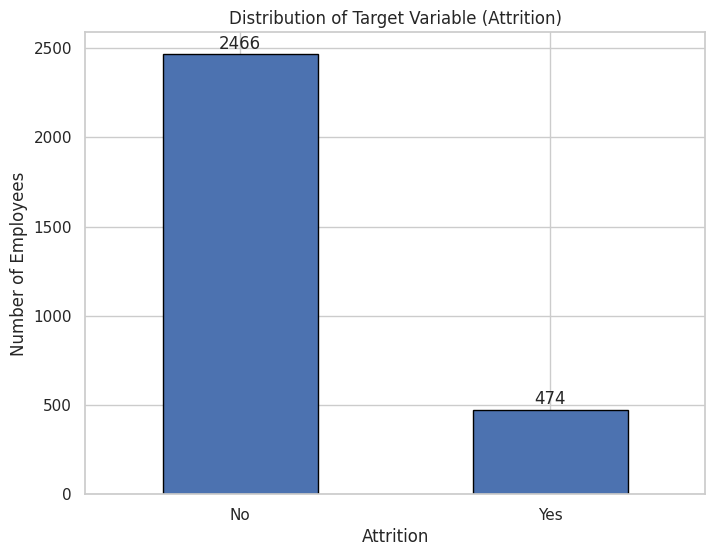

In [ ]:
# target variable
if 'Attrition' in data.columns:
    target_counts = data['Attrition'].value_counts()

    print(" Distribution for Target Variable (Attrition):")
    print("-" * 40)
    for category, count in target_counts.items():
        print(f"• {category}: {count} ({(count / len(data) * 100):.2f}%)")

    imbalance_ratio = target_counts.min() / target_counts.max()
    is_unbalanced = imbalance_ratio < 0.5
    print("\n Unbalanced?:", "Yes" if is_unbalanced else "No")
    print(f" Imbalance Ratio: {imbalance_ratio:.2f}")

    plt.figure(figsize=(8, 6))
    target_counts.plot(kind='bar', edgecolor='black')
    plt.title('Distribution of Target Variable (Attrition)')
    plt.xlabel('Attrition')
    plt.ylabel('Number of Employees')
    plt.xticks(rotation=0)
    for i, value in enumerate(target_counts):
        plt.text(i, value + 10, str(value), ha='center', va='bottom')
    plt.show()
else:
    print(" No column named 'Attrition' found in the dataset.")


This is a **classification problem.** The target variable, **Attrition**, is **categorical** and represents whether an employee has left the company (Yes) or stayed (No). The goal is to predict one of these two discrete classes based on employee-related features, making this a binary classification task.

The analysis of the target variable **Attrition** reveals a significant **class imbalance**. Out of 2,940 employees, 2,466 (83.88%) did not leave the company, while only 474 (16.12%) resigned. This imbalance results in an imbalance ratio of 0.19, indicating that the minority class (Yes) represents less than 20% of the total observations.

Class imbalance can pose challenges for machine learning models, as they might become biased toward predicting the majority class. As a result, specific strategies such as resampling techniques and adjusting class weights will need to be considered during model development to ensure balanced performance across both classes. The bar chart further emphasizes this disparity, visually illustrating the significant difference in class distribution.


 Cardinality of Categorical Variables:
----------------------------------------
• BusinessTravel: 3 unique values
• Department: 3 unique values
• EducationField: 6 unique values
• Gender: 2 unique values
• JobRole: 9 unique values
• MaritalStatus: 3 unique values
• Over18: 1 unique values
• Attrition: 2 unique values


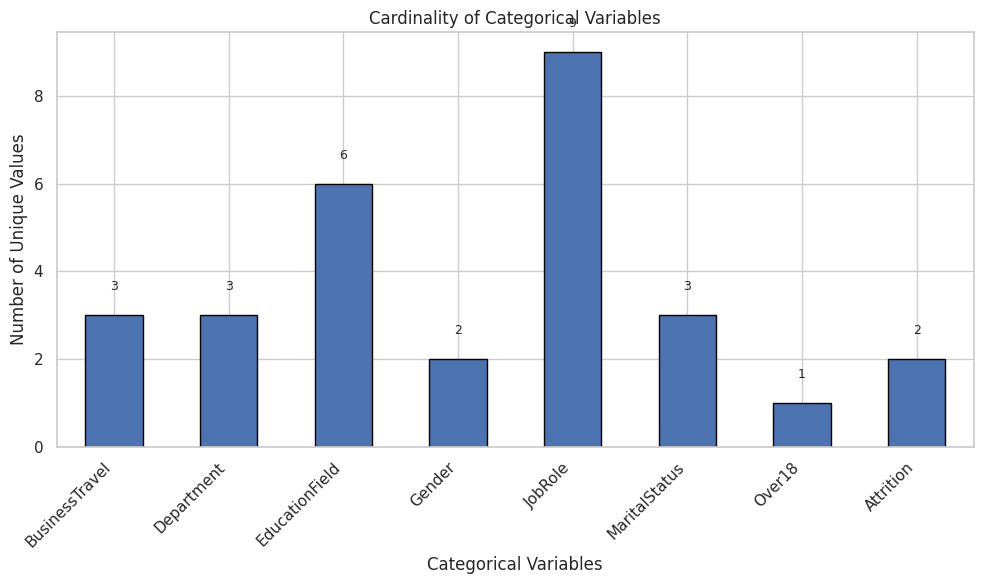

In [ ]:
# cardinality for categorical variables
categorical_cardinality = data[categorical_features].nunique()
print("\n Cardinality of Categorical Variables:")
print("-" * 40)
for col, cardinality in categorical_cardinality.items():
    print(f"• {col}: {cardinality} unique values")

plt.figure(figsize=(10, 6))
categorical_cardinality.plot(kind='bar', edgecolor='black')
plt.title('Cardinality of Categorical Variables')
plt.xlabel('Categorical Variables')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(categorical_cardinality):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


The analysis of categorical variable cardinality shows that most variables have low cardinality (2-3 unique values), such as `BusinessTravel`, `Department`, `Gender`, and `Attrition`. `Over18` has only 1 unique value and can be removed. `EducationField` has 6 unique values, while `JobRole` has the highest cardinality with 9 unique values, requiring more careful encoding.

As we have seen the dataset contains constant variables (`EmployeeCount`, `Over18`, and `StandardHours`) and an identifier column (`EmployeeID`) that do not provide useful information for predictive modeling. Constant variables lack variability, while ID columns are unique to each row and do not contribute to identifying patterns. Therefore, these columns will be removed during the preprocessing stage to simplify the dataset and improve model efficiency.

In [ ]:
columns_to_drop = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID']
data = data.drop(columns=columns_to_drop, axis=1)

# **2. Setup**

### **Appropriate test set size**

The next step is to split the dataset into training and testing sets. Using 20% of the dataset as the test set is a widely accepted standard in machine learning because it achieves a good balance between providing sufficient data for training and preserving enough data for reliable evaluation.

A 20% test split ensures the test set is large enough to represent the diversity of the data, capturing key patterns and reducing the risk of evaluation bias. Conversely, the 80% training set provides the model with ample data to learn effectively, minimizing the risk of underfitting. This division allows us to build a robust model while maintaining an unbiased estimate of its performance on unseen data.

In [ ]:
test_size = 0.2

X = data.drop(columns=['Attrition'])
y = data['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1470, stratify=y)

print(f"Training set: {X_train.shape[0]} rows \nTest set: {X_test.shape[0]} rows")

Training set: 2352 rows 
Test set: 588 rows


### **Defining the inner evaluation**

We will use **k-fold cross-validation** as our inner evaluation method because it is a robust technique to estimate model performance while minimizing the risk of overfitting. In k-fold cross-validation, the training data is split into `k` equal-sized subsets, or folds. The model is trained on `k-1` folds and tested on the remaining fold. This process is repeated `k` times, with each fold used as the test set once. The final performance is calculated as the average across all iterations. This method ensures that every part of the training data is used for both training and validation, providing a more reliable estimate of how the model will perform on unseen data. For our project, we will use **Stratified k-fold cross-validation** to maintain the class distribution in each fold, which is particularly important since we are working with a potentially imbalanced classification problem.

In [ ]:
# because our data is unbalanced, we use StratifiedKFold
inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1470)

## **Preprocessing for the training data**

Preprocessing is a critical step in building a machine-learning model, as the quality of the input data directly impacts the model's performance. Proper preprocessing ensures that the data is clean, consistent, and ready for analysis, minimizing biases and errors during model training.

To maintain efficiency and reproducibility, preprocessing will be handled using pipelines. Pipelines allow us to automate and standardize the sequence of preprocessing steps, reducing the risk of human error and ensuring that the same transformations are applied consistently to both the training and testing datasets.

\
**Preprocessing for K-Nearest Neighbors (KNN)**

The K-Nearest Neighbors (KNN) algorithm is highly sensitive to the scale of numerical features, as it relies on distance calculations to make predictions. Therefore:

- **Numerical Variables:** Will be **imputed** using the **mean** and subsequently **scaled** to standardize their range.
- **Categorical Variables:** Will be imputed using the **mode** and encoded using **One-Hot Encoding** to transform them into a format compatible with the model.

\
**Preprocessing for Decision Trees**

In contrast, Decision Tree-based algorithms are not sensitive to the scale of numerical variables, as they make splits based on thresholds rather than distances. Therefore:

- **Numerical Variables:** Will be imputed using the **mean**, but scaling is not required.
- **Categorical Variables:** Will be imputed using the **mode** and encoded with **One-Hot Encoding** to maintain interpretability and consistency.

In [ ]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# numeric pipeline for knn
numeric_transformer_knn = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# numeric pipeline for trees
numeric_transformer_tree = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])

# categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) ])

# preprocessing for knn
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_knn, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# preprocess for trees
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_tree, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_knn),
    ('classifier', KNeighborsClassifier())])

tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', DecisionTreeClassifier(random_state=1470))])

dummy_pipeline = Pipeline(steps=[
    ('classifier', DummyClassifier(strategy="most_frequent"))])



# 3.1. **Basic Methods without HPO**

The next step involves training, evaluating, and comparing three models: K-Nearest Neighbors (KNN), Decision Trees, and a Dummy Classifier. Each model will be evaluated using default hyperparameters to establish a baseline for performance comparison.

\
**Dummy Classifier**

The Dummy Classifier serves as a baseline model, using the strategy most_frequent. This means it will always predict the majority class. While it doesn't provide meaningful predictions, it offers a reference point to measure whether the other models truly add value.

\
**K-Nearest Neighbors (KNN)**

The KNN algorithm classifies data points based on the majority class of their nearest neighbors in the feature space. It is particularly sensitive to feature scaling and is ideal for smaller datasets but can become computationally expensive with large data.

\
**Decision Trees**

Decision Trees split data recursively based on feature thresholds to create a tree-like structure. They are intuitive, handle both numerical and categorical data, and are robust to unscaled numerical features.

Given that the dataset is highly imbalanced, with a significant majority of employees labeled as 'No Attrition', evaluating model performance using standard accuracy could lead to misleading results. A model predicting exclusively the majority class could still achieve high accuracy without actually being useful.

To address this, we will use the **Balanced Accuracy metric.** Balanced Accuracy calculates the average recall obtained on each class, ensuring that both the minority (Yes) and majority (No) classes are equally considered in the evaluation. This metric is particularly effective for imbalanced datasets because it penalizes models that perform poorly on the minority class, even if they perform well overall.

In [ ]:
print("Evaluating KNN Pipeline...")
start_knn = time()
knn_predictions = cross_val_predict(knn_pipeline, X_train, y_train, cv=inner)
knn_balanced_acc = balanced_accuracy_score(y_train, knn_predictions)
knn_accuracy = accuracy_score(y_train, knn_predictions)
knn_conf_matrix = confusion_matrix(y_train, knn_predictions)
end_knn = time()
knn_nohp_time = (round(end_knn-start_knn, 3))
print(f"KNN - Balanced Accuracy: {knn_balanced_acc:.4f}")
print(f"KNN - Normal Accuracy: {knn_accuracy:.4f}")
print("Execution time for KNN: ", round(end_knn-start_knn, 3), "seconds")
print("KNN - Confusion Matrix:")
print(knn_conf_matrix)

print("\nEvaluating Decision Tree Pipeline...")
start_trees = time()
tree_predictions = cross_val_predict(tree_pipeline, X_train, y_train, cv=inner)
tree_balanced_acc = balanced_accuracy_score(y_train, tree_predictions)
tree_accuracy = accuracy_score(y_train, tree_predictions)
tree_conf_matrix = confusion_matrix(y_train, tree_predictions)
end_trees = time()
trees_nohp_time = (round(end_trees-start_trees, 3))
print(f"Decision Tree - Balanced Accuracy: {tree_balanced_acc:.4f}")
print(f"Decision Tree - Normal Accuracy: {tree_accuracy:.4f}")
print("Decision Tree - Confusion Matrix:" )
print(tree_conf_matrix)
print("Execution time for Decision Trees: ", round(end_trees-start_trees, 3), "seconds")


print("\nEvaluating Dummy Classifier Pipeline...")
start_dummy = time()
dummy_predictions = cross_val_predict(dummy_pipeline, X_train, y_train, cv=inner)
dummy_balanced_acc = balanced_accuracy_score(y_train, dummy_predictions)
dummy_accuracy = accuracy_score(y_train, dummy_predictions)
dummy_conf_matrix = confusion_matrix(y_train, dummy_predictions)
end_dummy = time()
dummy_nohp_time = (round(end_dummy-start_dummy, 3))
print(f"Dummy Classifier - Balanced Accuracy: {dummy_balanced_acc:.4f}")
print(f"Dummy Classifier - Normal Accuracy: {dummy_accuracy:.4f}")
print("Dummy Classifier - Confusion Matrix:")
print(dummy_conf_matrix)
print("Execution time for Dummy Model: ", round(end_dummy-start_dummy, 3), "seconds")


Evaluating KNN Pipeline...
KNN - Balanced Accuracy: 0.6236
KNN - Normal Accuracy: 0.8584
Execution time for KNN:  0.311 seconds
KNN - Confusion Matrix:
[[1914   59]
 [ 274  105]]

Evaluating Decision Tree Pipeline...
Decision Tree - Balanced Accuracy: 0.8251
Decision Tree - Normal Accuracy: 0.8997
Decision Tree - Confusion Matrix:
[[1845  128]
 [ 108  271]]
Execution time for Decision Trees:  0.413 seconds

Evaluating Dummy Classifier Pipeline...
Dummy Classifier - Balanced Accuracy: 0.5000
Dummy Classifier - Normal Accuracy: 0.8389
Dummy Classifier - Confusion Matrix:
[[1973    0]
 [ 379    0]]
Execution time for Dummy Model:  0.092 seconds


The results show clear differences in performance when considering Balanced Accuracy, a key metric for imbalanced datasets.

The **Dummy Classifier**, serving as a baseline, achieved a Balanced Accuracy of **0.50**, indicating it failed to identify the minority class (Yes). Despite a high Normal Accuracy (83.89%), it simply predicts the majority class (No) every time.

The **KNN** model performed moderately, with a Balanced Accuracy of **0.6236**. While it slightly improved over the baseline, it still **struggles** to correctly **predict the minority class**, despite an overall Normal Accuracy of 85.84%.

The **Decision Tree** model outperformed both, achieving a Balanced Accuracy of **0.8251** and a Normal Accuracy of 89.97%. It shows a strong ability to identify both classes effectively, making it the most reliable model so far.

In conclusion, Decision Trees handle the class imbalance best, while KNN requires further tuning to improve its predictive power.

# 3.2. **Basic Methods with HPO**

Now that we have established a baseline performance for the models, the next step is to **optimize** their **hyperparameters** to further improve their predictive capabilities. This will be done using two widely used techniques: **Grid Search** and **Optuna**.

**Grid Search** systematically explores a predefined set of hyperparameter values, **evaluating all possible combinations** to identify the best-performing configuration based on a chosen evaluation metric, such as Balanced Accuracy. While effective, Grid Search can become computationally expensive when dealing with a large number of parameters or wide search spaces.

In contrast, **Optuna** is an **automated hyperparameter optimization** library that uses an intelligent sampling strategy, such as Tree-structured Parzen Estimators (TPE), to explore the hyperparameter space more efficiently. Instead of exhaustively testing all combinations, Optuna **adapts its search** based on **previous results**, focusing on the most promising areas of the hyperparameter space. This makes it a more scalable and computationally efficient approach compared to Grid Search, especially for complex models.

For the Grid Search the following hyperparameters are used:

1. **KNN Hyperparameter Grid**

  The hyperparameters for KNN focus on the core aspects of how neighbors are selected and distances are calculated:

  - **n_neighbors:** Represents the number of neighbors considered for classification. Values range from 3 to 31, increasing in steps of 2 to test both smaller and larger neighborhoods.
  - **weights:** Determines the influence of neighbors on the prediction.
    - distance: Closer neighbors have a higher influence.
    - uniform: All neighbors contribute equally, regardless of distance.
  -  **metric:** Defines the distance calculation method.
    - manhattan: Uses the sum of absolute differences.
    - euclidean: Uses the standard straight-line distance.


2. **Decision Tree Hyperparameter Grid**

  The hyperparameters for Decision Trees focus on controlling tree depth and node splits to prevent overfitting or underfitting:

  - **max_depth:** Controls the maximum depth of the tree. Values range from 2 to 45, including intermediate steps to balance model complexity and generalization.
  - **min_samples_split:** Defines the minimum number of samples required to split an internal node. Values range from 2 to 4, ensuring nodes aren't split excessively.
  - **min_samples_leaf:** Sets the minimum number of samples required per leaf node, with values from 2 to 4, preventing overly small leaf nodes.

In [ ]:
# hyperparameter spaces for each model
knn_param_grid = [
    {
        'classifier__n_neighbors': range(3, 31, 2),
        'classifier__weights': ['distance'],
        'classifier__metric': ['manhattan']
    },
    {
        'classifier__n_neighbors': range(3, 31, 2),
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean']
    }
]


tree_param_grid = {
    'classifier__max_depth': [2,5,15, 30, 35, 40, 45],
    'classifier__min_samples_split': range(2,5),
    'classifier__min_samples_leaf': range(2, 5)
}

### **KNN - Grid Search**


In [ ]:
knn_grid = GridSearchCV(
    knn_pipeline,
    param_grid=knn_param_grid,
    scoring=make_scorer(balanced_accuracy_score),
    cv=inner,
    n_jobs=-1
)

start_knn_hpo = time()
knn_grid.fit(X_train, y_train)
end_knn_hpo = time()

print("Execution time for KNN-grid Search:", round(end_knn_hpo-start_knn_hpo, 3), "seconds")

Execution time for KNN-grid Search: 16.029 seconds


In [ ]:
knn_results = pd.DataFrame(knn_grid.cv_results_)

knn_best_balanced_accuracy   = knn_grid.best_score_
knn_execution_time = round(end_knn_hpo - start_knn_hpo, 3)


knn_results = pd.concat([
    knn_results['params'].apply(pd.Series),
    knn_results[['mean_test_score', 'std_test_score', 'rank_test_score']]
], axis=1)

knn_results.columns = [
    'Metric', 'n_neighbors', 'Weights',
    'Mean Balanced Accuracy', 'Std Balanced Accuracy', 'Rank'
]

knn_results = knn_results.sort_values(by='Rank').reset_index(drop=True)

knn_results.head(10)

,Metric,n_neighbors,Weights,Mean Balanced Accuracy,Std Balanced Accuracy,Rank
0,manhattan,3,distance,0.846784,0.018364,1
1,manhattan,5,distance,0.835703,0.012590,2
2,manhattan,7,distance,0.829533,0.025909,3
3,manhattan,9,distance,0.818907,0.018826,4
4,euclidean,3,distance,0.807655,0.025440,5
5,manhattan,11,distance,0.794090,0.025774,6
6,euclidean,5,distance,0.782511,0.032087,7
7,manhattan,13,distance,0.779261,0.024044,8
8,manhattan,15,distance,0.772144,0.032998,9
9,manhattan,17,distance,0.765294,0.032043,10


The best-performing K-Nearest Neighbors (KNN) model achieved a Balanced Accuracy of **0.8468**, demonstrating strong predictive capability on the imbalanced dataset. This result was obtained using the following hyperparameters: `n_neighbors` set to 3, `weights` set to 'distance', and `metric` set to 'manhattan'. The use of the Manhattan distance metric proved more effective than the Euclidean alternative, while the distance-based weighting ensured that closer neighbors had a greater influence on predictions. Additionally, having only 3 neighbors optimized the model's local decision-making. The low Standard Deviation across cross-validation folds indicates consistent and reliable performance.

### **KNN - Optuna**

Now optuna is tried.

In [ ]:
knn_optuna_space={
     'classifier__n_neighbors': IntDistribution(3, 31, step=2),
      'classifier__weights': CategoricalDistribution(['uniform', 'distance']),
      'classifier__metric': CategoricalDistribution(['euclidean', 'manhattan'])
}
trees_optuna_space = {
    'classifier__max_depth': CategoricalDistribution([2,5,15, 30]),
    'classifier__min_samples_split': IntDistribution(2,5),
    'classifier__min_samples_leaf': IntDistribution(2, 5)
}

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
X_train = X_train.reset_index(drop=True)


def create_pipeline(params):
    return Pipeline([
        ('preprocessor', preprocessor_knn),
        ('classifier', KNeighborsClassifier(
            n_neighbors=params['n_neighbors'],
            weights=params['weights'],
            p=params['p']
        ))
    ])


def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 31),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2)
    }

    pipeline = create_pipeline(params)


    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1470)
    scores = []
    for train_idx, val_idx in inner_cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_val_fold)
        scores.append(balanced_accuracy_score(y_val_fold, preds))

    return np.mean(scores)

start_optuna = time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_optuna = time()

[I 2024-12-29 20:17:35,346] A new study created in memory with name: no-name-76cfdcb0-b537-400e-89c7-83179a6d0add
[I 2024-12-29 20:17:35,914] Trial 0 finished with value: 0.7105450883843935 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.7105450883843935.
[I 2024-12-29 20:17:37,498] Trial 1 finished with value: 0.5509796638676303 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.7105450883843935.
[I 2024-12-29 20:17:38,564] Trial 2 finished with value: 0.5139848989562514 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.7105450883843935.
[I 2024-12-29 20:17:39,457] Trial 3 finished with value: 0.5364533480781566 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.7105450883843935.
[I 2024-12-29 20:17:41,178] Trial 4 finished with value: 0.7589334250939306 and parameters: {'n_neighbors': 19, 'weights':

In [ ]:
optuna_best_balanced_accuracy = study.best_value
optuna_execution_time = round(end_optuna - start_optuna, 3)

print(f"Total Execution Time: {optuna_execution_time} seconds")

best_pipeline_knn_opt = create_pipeline(study.best_params)
best_pipeline_knn_opt.fit(X_train, y_train)

optuna_results = pd.DataFrame([
    {
        'Trial': trial.number,
        'n_neighbors': trial.params['n_neighbors'],
        'weights': trial.params['weights'],
        'p': trial.params['p'],
        'Balanced Accuracy': trial.value
    }
    for trial in study.trials if trial.value is not None
])

optuna_results = optuna_results.sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)

print("\n Optuna Hyperparameter Tuning Results:")
optuna_results.head(11)


Total Execution Time: 32.299 seconds

 Optuna Hyperparameter Tuning Results:


,Trial,n_neighbors,weights,p,Balanced Accuracy
0,31,3,distance,1,0.846784
1,15,3,distance,1,0.846784
2,23,3,distance,1,0.846784
3,21,3,distance,1,0.846784
4,44,3,distance,1,0.846784
5,41,3,distance,1,0.846784
6,18,3,distance,1,0.846784
7,35,3,distance,1,0.846784
8,12,3,distance,1,0.846784
9,42,4,distance,1,0.843882


The hyperparameter optimization using **Optuna** consistently identified the configuration `n_neighbors`=3, `weights`='distance', and `p`=1 (Manhattan distance metric) as the optimal combination, achieving a Balanced Accuracy of **0.8468** across multiple trials. This result highlights the robustness of the chosen parameters, with the distance-based weighting prioritizing closer neighbors and the Manhattan distance proving more effective than other metrics. The stability of these results across several trials suggests that the model's performance is well-optimized within the explored parameter space.

### **Decision Trees - Grid Search**

In [ ]:
tree_grid = GridSearchCV(
    tree_pipeline,
    param_grid=tree_param_grid,
    scoring=make_scorer(balanced_accuracy_score),
    cv=inner,
    n_jobs=-1
)

start_tree_hpo = time()
tree_grid.fit(X_train, y_train)
end_tree_hpo = time()
print("Execution time for Decision Tree with Grid Search: ", round(end_tree_hpo-start_tree_hpo, 3), "seconds")

Execution time for Decision Tree with Grid Search:  16.141 seconds


In [ ]:
tree_grid_results = pd.DataFrame(tree_grid.cv_results_)

tree_grid_best_balanced_accuracy = tree_grid.best_score_
tree_grid_execution_time = round(end_tree_hpo - start_tree_hpo, 3)

tree_grid_results = pd.concat([
    tree_grid_results['params'].apply(pd.Series),
    tree_grid_results[['mean_test_score', 'std_test_score', 'rank_test_score']]
], axis=1)

tree_grid_results.columns = [
    'Max_depth', 'Min_sample_splits', 'Min_samples_leaf',
    'Mean Balanced Accuracy', 'Std Balanced Accuracy', 'Rank'
]

tree_grid_results = tree_grid_results.sort_values(by='Rank').reset_index(drop=True)

tree_grid_results

,Max_depth,Min_sample_splits,Min_samples_leaf,Mean Balanced Accuracy,Std Balanced Accuracy,Rank
0,35,2,2,0.767788,0.033855,1
1,35,2,4,0.767788,0.033855,1
2,30,2,4,0.767788,0.033855,1
3,30,2,3,0.767788,0.033855,1
4,30,2,2,0.767788,0.033855,1
...,...,...,...,...,...,...
58,2,3,3,0.521802,0.028476,55
59,2,3,2,0.521802,0.028476,55
60,2,2,4,0.521802,0.028476,55
61,2,2,3,0.521802,0.028476,55


The hyperparameter optimization results for the Decision Tree model reveal patterns in how parameters like Max_depth, Min_samples_splits, and Min_samples_leaf influence performance. The highest Balanced Accuracy of **0.7678** was consistently achieved across several configurations, all sharing similar parameter values. Specifically, configurations with Max_depth set to 30 or 35, Min_samples_splits set to 2, and varying values of Min_samples_leaf (2, 3, or 4) performed equally well. This indicates that deeper trees, combined with a minimal splitting threshold, provide the best results in terms of Balanced Accuracy.

The low standard deviation (0.0339) among the top-performing configurations indicates consistency across cross-validation folds, highlighting the robustness of the selected hyperparameter ranges.

### **Decision Trees - Optuna**

In [ ]:
def create_pipeline(params):
    return Pipeline([
        ('preprocessor', preprocessor_tree),
        ('classifier', DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            ccp_alpha=params['ccp_alpha'],
            random_state=1470
        ))
    ])


def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.01)
    }

    pipeline = create_pipeline(params)

    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1470)
    scores = []
    for train_idx, val_idx in inner_cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_val_fold)
        scores.append(balanced_accuracy_score(y_val_fold, preds))

    return np.mean(scores)

start_optuna = time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_optuna = time()

[I 2024-12-29 20:22:53,575] A new study created in memory with name: no-name-540e4876-1253-499a-9d55-f2d21ebe1cde
[I 2024-12-29 20:22:54,209] Trial 0 finished with value: 0.6082285582877066 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'ccp_alpha': 0.0030462116084748326}. Best is trial 0 with value: 0.6082285582877066.
[I 2024-12-29 20:22:54,993] Trial 1 finished with value: 0.6227613942650754 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 4, 'ccp_alpha': 0.002753605974272331}. Best is trial 1 with value: 0.6227613942650754.
[I 2024-12-29 20:22:55,762] Trial 2 finished with value: 0.5197712692384433 and parameters: {'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 4, 'ccp_alpha': 0.008446552766086302}. Best is trial 1 with value: 0.6227613942650754.
[I 2024-12-29 20:22:56,421] Trial 3 finished with value: 0.5781550280636372 and parameters: {'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 8, 'ccp

In [ ]:
trees_optuna_best_balanced_accuracy = study.best_value
trees_optuna_execution_time = round(end_optuna - start_optuna, 3)

print(f"Total Execution Time: {trees_optuna_execution_time} seconds")

best_pipeline_trees_opt = create_pipeline(study.best_params)
best_pipeline_trees_opt.fit(X_train, y_train)

optuna_results_trees = pd.DataFrame([
    {
        'Trial': trial.number,
        'max_depth': trial.params['max_depth'],
        'min_samples_split': trial.params['min_samples_split'],
        'min_samples_leaf': trial.params['min_samples_leaf'],
        'ccp_alpha': trial.params['ccp_alpha'],
        'Balanced Accuracy': trial.value
    }
    for trial in study.trials if trial.value is not None
])

optuna_results_trees = optuna_results_trees.sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)

print("\n Optuna Hyperparameter Tuning Results:")
optuna_results_trees.head(11)


Total Execution Time: 22.957 seconds

 Optuna Hyperparameter Tuning Results:


,Trial,max_depth,min_samples_split,min_samples_leaf,ccp_alpha,Balanced Accuracy
0,44,13,2,1,0.000632,0.800290
1,41,14,3,2,0.000601,0.776993
2,46,14,2,2,0.000568,0.776993
3,36,14,2,2,0.000563,0.776740
4,43,13,2,3,0.000656,0.758115
5,25,11,5,3,0.000015,0.757307
6,34,11,2,3,0.000786,0.746982
7,47,15,2,1,0.001158,0.736785
8,32,11,3,4,0.000002,0.736479
9,28,14,11,2,0.000042,0.726411


The Optuna hyperparameter optimization for the Decision Tree model revealed key insights into the relationship between hyperparameters and model performance. The **highest Balanced Accuracy of 0.80** + was achieved in **Trial 44**, with the following configuration: `max_depth`=13, `min_samples_split`=2, `min_samples_leaf`=1, and `ccp_alpha`=0.000632. These results suggest that a relatively deep tree, combined with moderate constraints on node splitting and leaf size, provides the best balance between capturing complexity and avoiding overfitting.

In [ ]:
new_results = [
    {'Model': 'Dummy Classifier', 'Balanced Accuracy': dummy_balanced_acc, 'Execution Time (s)': dummy_nohp_time},
    {'Model': 'KNN', 'Balanced Accuracy': knn_balanced_acc, 'Execution Time (s)': knn_nohp_time },
    {'Model': 'Decision Tree', 'Balanced Accuracy': tree_balanced_acc, 'Execution Time (s)': trees_nohp_time },
    {'Model': 'KNN Grid Search', 'Balanced Accuracy': knn_best_balanced_accuracy, 'Execution Time (s)': knn_execution_time},
    {'Model': 'KNN Optuna', 'Balanced Accuracy': optuna_best_balanced_accuracy, 'Execution Time (s)': optuna_execution_time},
    {'Model': 'Decision Tree Grid Search', 'Balanced Accuracy': tree_grid_best_balanced_accuracy, 'Execution Time (s)': tree_grid_execution_time},
    {'Model': 'Decision Tree Optuna', 'Balanced Accuracy': trees_optuna_best_balanced_accuracy, 'Execution Time (s)': trees_optuna_execution_time}
]

results_df = pd.DataFrame(new_results)
results_df = results_df.sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)
results_df

,Model,Balanced Accuracy,Execution Time (s)
0,KNN Grid Search,0.846784,16.029
1,KNN Optuna,0.846784,32.299
2,Decision Tree,0.825082,0.413
3,Decision Tree Optuna,0.800290,22.957
4,Decision Tree Grid Search,0.767788,16.141
5,KNN,0.623571,0.311
6,Dummy Classifier,0.500000,0.092


The comparison table summarizes the performance of various models based on **Balanced Accuracy and Execution Time.**

The **KNN Grid Search** and **KNN Optuna** models achieved the highest Balanced Accuracy of **0.8468**, demonstrating their effectiveness in handling the dataset. However, the KNN Optuna model required slightly more computational time (32.299 seconds) compared to KNN Grid Search (16 seconds), indicating a trade-off between hyperparameter optimization strategies.

The **Decision Tree** (default settings) achieved a Balanced Accuracy of 0.8251 with a **remarkably low execution time** (0.4 seconds), showcasing its computational efficiency but slightly lower predictive power compared to the optimized KNN models. On the other hand, the **Decision Tree Optuna** and **Decision Tree Grid Search** models reached Balanced Accuracy scores of **0.8** and **0.7678**, respectively. While these scores are lower than those of the best KNN models, they required more time (22.98 seconds and 16.14 seconds, respectively), reflecting the complexity of optimizing tree-based models.

The basic **KNN model** (default settings) achieved a moderate Balanced Accuracy of 0.6236 with a quick execution time (0.3 seconds), suggesting that hyperparameter tuning significantly impacts KNN's predictive power.

Finally, the **Dummy Classifie**r, serving as a baseline, obtained a Balanced Accuracy of 0.5000 with the shortest execution time (0.09 seconds). This highlights the value added by all other models, as they significantly outperform this naive benchmark.


#**4. Dealing with Class Imbalance**


### **SMOTE**

**SMOTE (Synthetic Minority Over-sampling Technique)** is a method used for addressing the challenge of class imbalance in machine learning datasets. Class imbalance can lead to biased model performance, where the model tends to favor the majority class, often resulting in poor predictive accuracy for the minority class.

SMOTE generates synthetic samples created by interpolating between existing minority class samples. Specifically, it identifies the k-nearest neighbors of a minority class instance and generates new samples by creating points along the line segments connecting the original instance with its neighbors. This approach enriches the feature space of the minority class, helping the model learn more meaningful patterns rather than overfitting to repeated data points.

In [ ]:

# Pipelines for preprocessing
# ------------------------------------------------------------------------------
numeric_pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
numeric_pipeline_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Columns transformer
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline_knn, make_column_selector(dtype_include=['int', 'float'])),
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object', 'category']))
    ]
)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline_tree, make_column_selector(dtype_include=['int', 'float'])),
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object', 'category']))
    ]
)

# HPO for GridSearch
# ------------------------------------------------------------------------------
tree_param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__ccp_alpha': np.linspace(0, 0.01, 5)
}
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

#### KNN - SMOTE + GRID SEARCH

In [ ]:
pipeline_knn_smote_grid = ImbPipeline([
    ('preprocessor', preprocessor_knn),
    ('smote', SMOTE(random_state=1470)),
    ('classifier', KNeighborsClassifier())
])

knn_smote_grid_search = GridSearchCV(
    estimator=pipeline_knn_smote_grid,
    param_grid=knn_param_grid,
    scoring='balanced_accuracy',
    cv=inner,
    refit=True,
    n_jobs=-1
)

# GridSearchCV
start_knn_smote_grid = time()
knn_smote_grid_search.fit(X_train, y_train)
end_knn_smote_grid = time()

In [ ]:
knn_smote_grid_results = pd.DataFrame(knn_smote_grid_search.cv_results_)

knn_smote_grid_best_balanced_accuracy = knn_smote_grid_search.best_score_
knn_smote_grid_execution_time = round(end_knn_smote_grid - start_knn_smote_grid, 3)

print(f"Total Execution Time: {knn_smote_grid_execution_time} seconds")

knn_smote_grid_results = pd.concat([
    knn_smote_grid_results['params'].apply(pd.Series),
    knn_smote_grid_results[['mean_test_score', 'std_test_score', 'rank_test_score']]
], axis=1)

knn_smote_grid_results.columns = [
    'Metric', 'n_neighbors', 'Weights',
    'Mean Balanced Accuracy', 'Std Balanced Accuracy', 'Rank'
]

knn_smote_grid_results = knn_smote_grid_results.sort_values(by='Rank').reset_index(drop=True)

knn_smote_grid_results.head(10)


Total Execution Time: 12.824 seconds


,Metric,n_neighbors,Weights,Mean Balanced Accuracy,Std Balanced Accuracy,Rank
0,7,1,distance,0.863296,0.012379,1
1,5,1,distance,0.860973,0.012304,2
2,9,1,distance,0.859846,0.010906,3
3,3,1,distance,0.856181,0.014758,4
4,11,1,distance,0.853916,0.006624,5
5,3,2,distance,0.851293,0.015112,6
6,5,2,distance,0.837643,0.015320,7
7,3,1,uniform,0.825720,0.013411,8
8,7,2,distance,0.823242,0.012897,9
9,9,2,distance,0.810502,0.014170,10


The **K-Nearest Neighbors (KNN) model with SMOTE and Grid Search** reveals a strong performance in handling class imbalance, with the **best configuration achieving a Balanced Accuracy of 0.8633**. This was obtained using the following hyperparameters: **`n_neighbors=7`**, **`weights='distance'`**, and **`Metric=1` (Manhattan distance)**. This configuration leverages a moderate number of neighbors and distance-based weighting, ensuring that closer neighbors have more influence on predictions.

The table also highlights other high-performing configurations, such as **`n_neighbors=5`**, which achieved a **Balanced Accuracy of 0.8610**, and **`n_neighbors=9`**, with a **Balanced Accuracy of 0.8598**. The use of **distance-based weighting** consistently outperformed the uniform alternative, as seen in the slightly lower score for **`n_neighbors=3` and `weights='uniform'` (Balanced Accuracy = 0.8257)**.

The **execution time of 12 seconds** indicates that Grid Search provided a thorough yet efficient exploration of the hyperparameter space. The low **standard deviation across folds** demonstrates that these results are stable and reliable. These findings confirm the effectiveness of combining SMOTE with carefully tuned KNN hyperparameters to address class imbalance and improve predictive performance.

#### KNN - SMOTE + OPTUNA

In [ ]:
# Pipeline with SMOTE
def create_pipeline_smote_optuna_knn(params):
    return ImbPipeline([
        ('preprocessor', preprocessor_knn),
        ('smote', SMOTE(random_state=1470)),
        ('classifier', KNeighborsClassifier(
            n_neighbors=params['n_neighbors'],
            weights=params['weights'],
            p=params['p']
        ))
    ])

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
X_train = X_train.reset_index(drop=True)

def objective(trial):
    # HPO for Optuna
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 15),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2)  # 1 for Manhattan, 2 for Euclidean
    }

    pipeline = create_pipeline_smote_optuna_knn(params)

    scores = []
    for train_idx, val_idx in inner.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_val_fold)
        scores.append(balanced_accuracy_score(y_val_fold, preds))

    return np.mean(scores)


start_smote_optuna_knn = time()
knn_smote_optuna = optuna.create_study(direction='maximize')
knn_smote_optuna.optimize(objective, n_trials=50)
end_smote_optuna_knn = time()

[I 2024-12-29 20:28:35,964] A new study created in memory with name: no-name-c209fea4-9532-44b9-a209-4bbf2c566c6d
[I 2024-12-29 20:28:37,664] Trial 0 finished with value: 0.8556535338539113 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.8556535338539113.
[I 2024-12-29 20:28:38,668] Trial 1 finished with value: 0.8308734481580806 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.8556535338539113.
[I 2024-12-29 20:28:39,608] Trial 2 finished with value: 0.7165507867851212 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.8556535338539113.
[I 2024-12-29 20:28:40,522] Trial 3 finished with value: 0.8512926182319512 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.8556535338539113.
[I 2024-12-29 20:28:41,360] Trial 4 finished with value: 0.7938631899094907 and parameters: {'n_neighbors': 15, 'weights':

In [ ]:
knn_smote_optuna_best_balanced_accuracy = knn_smote_optuna.best_value
knn_smote_optuna_execution_time = round(end_smote_optuna_knn - start_smote_optuna_knn, 3)

print(f"Total Execution Time: {knn_smote_optuna_execution_time} seconds")

best_pipeline_knn_opt_smote = create_pipeline_smote_optuna_knn(knn_smote_optuna.best_params)
best_pipeline_knn_opt_smote.fit(X_train, y_train)

knn_smote_optuna_results = pd.DataFrame([
    {
        'Trial': trial.number,
        'n_neighbors': trial.params['n_neighbors'],
        'weights': trial.params['weights'],
        'p': trial.params['p'],
        'Balanced Accuracy': trial.value
    }
    for trial in knn_smote_optuna.trials if trial.value is not None
])

knn_smote_optuna_results = knn_smote_optuna_results.sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)

print("\n Optuna Hyperparameter Tuning Results:")
knn_smote_optuna_results.head(11)


Total Execution Time: 36.844 seconds

 Optuna Hyperparameter Tuning Results:


,Trial,n_neighbors,weights,p,Balanced Accuracy
0,25,7,distance,1,0.863296
1,8,7,distance,1,0.863296
2,21,7,distance,1,0.863296
3,20,7,distance,1,0.863296
4,30,7,distance,1,0.863296
5,31,7,distance,1,0.863296
6,16,7,distance,1,0.863296
7,41,7,distance,1,0.863296
8,12,7,distance,1,0.863296
9,45,7,distance,1,0.863296


The **K-Nearest Neighbors (KNN) model with SMOTE and Optuna hyperparameter optimization** demonstrates strong performance in addressing class imbalance. The **best-performing configuration** achieved a **Balanced Accuracy of 0.8633**, with the following hyperparameters: **`n_neighbors` set to 7**, **`weights` set to 'distance'**, and **`p` set to 1**, indicating the use of the **Manhattan distance metric**. This result suggests that the model benefits from a moderate number of neighbors and distance-based weighting, which gives higher importance to closer points during classification.

Interestingly, the **top-performing trials (Trials 25, 8, 21, 20, and 30)** consistently share the same hyperparameter values, highlighting a stable optimal configuration. Slightly lower accuracy values (**0.8622**) were observed in configurations with **`n_neighbors` set to 6**, reinforcing the importance of fine-tuning this parameter for optimal results.

The **execution time of 36 seconds** indicates that Optuna efficiently explored the hyperparameter space, converging on a reliable configuration without excessive computational overhead. Overall, the results emphasize the effectiveness of combining **SMOTE for handling class imbalance** with **Optuna for hyperparameter optimization**, resulting in a model capable of delivering consistent and balanced predictions.

#### Decision Trees - SMOTE + GRID SEARCH

In [ ]:
pipeline_tree_smote_grid = ImbPipeline([
    ('preprocessor', preprocessor_tree),
    ('smote', SMOTE(random_state=1470)),
    ('classifier', DecisionTreeClassifier(random_state=1470))
])

tree_smote_grid_search = GridSearchCV(
    estimator=pipeline_tree_smote_grid,
    param_grid=tree_param_grid,
    scoring='balanced_accuracy',
    cv=inner,
    refit=True,
    n_jobs=-1,
    return_train_score=True
)

# GridSearchCV
start_tree_smote_grid = time()
tree_smote_grid_search.fit(X_train, y_train)
end_tree_smote_grid = time()


In [ ]:
tree_smote_grid_results = pd.DataFrame(tree_smote_grid_search.cv_results_)

tree_smote_grid_best_balanced_accuracy = tree_smote_grid_search.best_score_
tree_smote_grid_execution_time = round(end_tree_smote_grid - start_tree_smote_grid, 3)

print(f"Total Execution Time: {tree_smote_grid_execution_time} seconds")

tree_smote_grid_results = pd.concat([
    tree_smote_grid_results['params'].apply(pd.Series),
    tree_smote_grid_results[['mean_test_score', 'std_test_score', 'rank_test_score']]
], axis=1)

tree_smote_grid_results.columns = [
    'Ccp_alpha', 'Max_depth', 'Min_sample_splits', 'Min_samples_leaf',
    'Mean Balanced Accuracy', 'Std Balanced Accuracy', 'Rank'
]

tree_smote_grid_results['Max_depth'] = tree_smote_grid_results['Max_depth'].fillna('No limit')
tree_smote_grid_results = tree_smote_grid_results.sort_values(by='Rank').reset_index(drop=True)

tree_smote_grid_results.head(10)


Total Execution Time: 96.134 seconds


,Ccp_alpha,Max_depth,Min_sample_splits,Min_samples_leaf,Mean Balanced Accuracy,Std Balanced Accuracy,Rank
0,0.0,No limit,1.0,2.0,0.814207,0.033957,1
1,0.0,No limit,1.0,5.0,0.795357,0.034322,2
2,0.0,10.0,1.0,2.0,0.792057,0.029884,3
3,0.0,No limit,2.0,2.0,0.791097,0.027621,4
4,0.0,No limit,2.0,5.0,0.787876,0.025103,5
5,0.0,10.0,2.0,2.0,0.785357,0.027195,6
6,0.0,10.0,1.0,5.0,0.780625,0.031857,7
7,0.0,10.0,2.0,5.0,0.778034,0.021911,8
8,0.0,No limit,1.0,10.0,0.774319,0.037933,9
9,0.0,10.0,1.0,10.0,0.769589,0.025913,10


The **Decision Tree with SMOTE and Grid Search** results reveal the performance impact of different hyperparameter configurations on **Balanced Accuracy**. The **best-performing configuration** achieved a **Balanced Accuracy of 0.8142**, with **`Max_depth`** set to **'No limit'**, **`Min_sample_splits` at 1**, and **`Min_samples_leaf` at 2**, suggesting that unrestricted tree depth and minimal constraints on splits and leaf sizes can capture complex patterns in the data effectively. However, configurations with limited depth (`Max_depth = 10`) and slightly adjusted parameters still delivered competitive results, with Balanced Accuracy values exceeding **0.792** across the top 10 ranked trials. The **standard deviation remains relatively low**, indicating consistent performance across cross-validation folds. These results suggest that fine-tuning parameters such as `Max_depth`, `Min_sample_splits`, and `Min_samples_leaf`, in combination with SMOTE, significantly improves the classifier's ability to handle class imbalance.

#### Decision Trees - SMOTE + OPTUNA

In [ ]:
# Pipeline with SMOTE
def create_pipeline_tree_smote_optuna(params):
    return ImbPipeline([
        ('preprocessor', preprocessor_tree),
        ('smote', SMOTE(random_state=1470)),
        ('classifier', DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            ccp_alpha=params['ccp_alpha'],
            random_state=1470
        ))
    ])


In [ ]:
def objective(trial):
    # HPO for Optuna
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.01)
    }

    pipeline = create_pipeline_tree_smote_optuna(params)

    scores = []
    for train_idx, val_idx in inner.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_val_fold)
        scores.append(balanced_accuracy_score(y_val_fold, preds))

    return np.mean(scores)

start_smote_optuna_tree = time()
tree_smote_optuna = optuna.create_study(direction='maximize')
tree_smote_optuna.optimize(objective, n_trials=50)
end_smote_optuna_tree = time()


[I 2024-12-29 20:33:50,386] A new study created in memory with name: no-name-3c055d19-813f-400d-a93e-956f4da41435
[I 2024-12-29 20:33:50,796] Trial 0 finished with value: 0.7713475066255885 and parameters: {'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 1, 'ccp_alpha': 0.0005689028788511052}. Best is trial 0 with value: 0.7713475066255885.
[I 2024-12-29 20:33:51,204] Trial 1 finished with value: 0.6970573853189809 and parameters: {'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 8, 'ccp_alpha': 0.004751081924480087}. Best is trial 0 with value: 0.7713475066255885.
[I 2024-12-29 20:33:51,530] Trial 2 finished with value: 0.7145424280034405 and parameters: {'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 7, 'ccp_alpha': 0.0022211891200921876}. Best is trial 0 with value: 0.7713475066255885.
[I 2024-12-29 20:33:51,879] Trial 3 finished with value: 0.7330603139925893 and parameters: {'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 8, 'cc

In [ ]:
trees_smote_optuna_best_balanced_accuracy = tree_smote_optuna.best_value
trees_smote_optuna_execution_time = round(end_smote_optuna_tree - start_smote_optuna_tree, 3)

print(f"Total Execution Time: {trees_smote_optuna_execution_time} seconds")

best_pipeline_trees_opt_smote = create_pipeline_tree_smote_optuna(tree_smote_optuna.best_params)
best_pipeline_trees_opt_smote.fit(X_train, y_train)

smote_optuna_results_trees = pd.DataFrame([
    {
        'Trial': trial.number,
        'max_depth': trial.params['max_depth'],
        'min_samples_split': trial.params['min_samples_split'],
        'min_samples_leaf': trial.params['min_samples_leaf'],
        'ccp_alpha': trial.params['ccp_alpha'],
        'Balanced Accuracy': trial.value
    }
    for trial in tree_smote_optuna.trials if trial.value is not None
])

smote_optuna_results_trees = smote_optuna_results_trees.sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)

print("\n Optuna Hyperparameter Tuning Results:")
smote_optuna_results_trees.head(11)


Total Execution Time: 22.131 seconds

 Optuna Hyperparameter Tuning Results:


,Trial,max_depth,min_samples_split,min_samples_leaf,ccp_alpha,Balanced Accuracy
0,12,19,2,1,0.000203,0.814207
1,11,19,3,1,0.000152,0.811593
2,44,20,3,1,0.000497,0.801793
3,43,20,5,1,0.000526,0.794755
4,23,19,4,2,0.000086,0.791097
5,42,18,3,1,0.000670,0.783344
6,33,16,5,2,0.000832,0.779246
7,48,19,6,2,0.000067,0.775806
8,41,18,3,3,0.000591,0.775328
9,15,18,2,3,0.000103,0.774990


The **Decision Tree with SMOTE and Optuna Hyperparameter Optimization** results demonstrate the impact of fine-tuned hyperparameters on **Balanced Accuracy**. The **best-performing configuration** achieved a **Balanced Accuracy of 0.81**, with **`max_depth` set to 19**, **`min_samples_split` at 2**, **`min_samples_leaf` at 1**, and a **`ccp_alpha` value of 0.000203**. This configuration suggests that moderate tree depth, combined with minimal constraints on splits and leaf size, effectively balances model complexity and generalization.

The top-performing trials consistently feature **shallow to moderate tree depths (17-19)**, with lower values of **`ccp_alpha`**, indicating minimal pruning. Additionally, the parameter **`min_samples_leaf`** was often set to **1**, highlighting the importance of allowing leaves to capture finer patterns in the data.  

While the **Balanced Accuracy** scores across the top configurations remain stable, the slight variations emphasize the sensitivity of Decision Tree models to hyperparameter changes. The **execution time of 22 seconds** reflects the computational efficiency of Optuna's optimization process. These results reinforce the importance of systematically tuning hyperparameters, as even slight adjustments can yield measurable improvements in handling class imbalance effectively.

In [ ]:
# Add new model results to the DataFrame
new_results = [
    {'Model': 'KNN SMOTE Grid Search', 'Balanced Accuracy': knn_smote_grid_best_balanced_accuracy, 'Execution Time (s)': knn_smote_grid_execution_time},
    {'Model': 'KNN SMOTE Optuna', 'Balanced Accuracy': knn_smote_optuna_best_balanced_accuracy, 'Execution Time (s)': knn_smote_optuna_execution_time},
    {'Model': 'Decision Tree SMOTE Grid Search', 'Balanced Accuracy': tree_smote_grid_best_balanced_accuracy, 'Execution Time (s)': tree_smote_grid_execution_time},
    {'Model': 'Decision Tree SMOTE Optuna', 'Balanced Accuracy': trees_smote_optuna_best_balanced_accuracy, 'Execution Time (s)': trees_smote_optuna_execution_time}
]

# Concatenate with the existing DataFrame
results_df = pd.concat([results_df, pd.DataFrame(new_results)], ignore_index=True)

results_df = results_df.sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)
results_df


,Model,Balanced Accuracy,Execution Time (s)
0,KNN SMOTE Grid Search,0.863296,12.824
1,KNN SMOTE Optuna,0.863296,36.844
2,KNN Grid Search,0.846784,16.029
3,KNN Optuna,0.846784,32.299
4,Decision Tree,0.825082,0.413
5,Decision Tree SMOTE Grid Search,0.814207,96.134
6,Decision Tree SMOTE Optuna,0.814207,22.131
7,Decision Tree Optuna,0.800290,22.957
8,Decision Tree Grid Search,0.767788,16.141
9,KNN,0.623571,0.311


### **Class Weights**

**Class weights** are a technique used in machine learning to address **class imbalance** in datasets. When training a model on imbalanced data, the algorithm might become biased towards predicting the majority class, as it minimizes the overall error more easily by ignoring the minority class. Class weights counteract this bias by assigning a **higher penalty (weight)** to misclassifications from the minority class, making the model pay more attention to these samples during training. This approach ensures that both classes contribute more equally to the model's learning process, leading to more balanced and fair predictions across all classes.

#### Decision Trees - Class Weights + Grid Search

In [ ]:
tree_weight_grid_pipeline = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', DecisionTreeClassifier(random_state=1470, class_weight='balanced'))
])

tree_weight_grid_search = GridSearchCV(
    estimator=tree_weight_grid_pipeline,
    param_grid=tree_param_grid,
    scoring='balanced_accuracy',
    cv=inner,
    refit=True,
    n_jobs=-1,
    return_train_score=True
)

# GridSearchCV
start_tree_weight_grid = time()
tree_weight_grid_search.fit(X_train, y_train)
end_tree_weight_grid = time()


In [ ]:
tree_weight_grid_results = pd.DataFrame(tree_weight_grid_search.cv_results_)

tree_weight_grid_best_balanced_accuracy = tree_weight_grid_search.best_score_
tree_weight_grid_execution_time = round(end_tree_weight_grid - start_tree_weight_grid, 3)

print(f"Total Execution Time: {tree_weight_grid_execution_time} seconds")

tree_weight_grid_results = pd.concat([
    tree_weight_grid_results['params'].apply(pd.Series),
    tree_weight_grid_results[['mean_test_score', 'std_test_score', 'rank_test_score']]
], axis=1)

tree_weight_grid_results.columns = [
    'Ccp_alpha', 'Max_depth', 'Min_sample_splits', 'Min_samples_leaf',
    'Mean Balanced Accuracy', 'Std Balanced Accuracy', 'Rank'
]

tree_weight_grid_results['Max_depth'] = tree_weight_grid_results['Max_depth'].fillna('No limit')
tree_weight_grid_results = tree_weight_grid_results.sort_values(by='Rank').reset_index(drop=True)

tree_weight_grid_results.head(10)


Total Execution Time: 69.664 seconds


,Ccp_alpha,Max_depth,Min_sample_splits,Min_samples_leaf,Mean Balanced Accuracy,Std Balanced Accuracy,Rank
0,0.0,No limit,1.0,2.0,0.807545,0.038815,1
1,0.0,No limit,2.0,5.0,0.803536,0.035614,2
2,0.0,No limit,2.0,2.0,0.802546,0.037306,3
3,0.0,10.0,1.0,5.0,0.800351,0.039089,4
4,0.0,10.0,2.0,5.0,0.800087,0.044099,5
5,0.0,No limit,2.0,10.0,0.796338,0.043969,6
6,0.0,10.0,1.0,2.0,0.794040,0.039298,7
7,0.0,10.0,2.0,10.0,0.793544,0.039409,8
8,0.0,10.0,2.0,2.0,0.792682,0.038035,9
9,0.0,No limit,1.0,5.0,0.789546,0.027221,10


The **Decision Tree model with Class Weights (`class_weight='balanced'`) and Grid Search** shows consistent results across different hyperparameter combinations. The **best-performing configurations** all achieved a **Balanced Accuracy of 0.807**, indicating stability across the top-ranked trials. The hyperparameters varied slightly, with **`Max_depth` values ranging from 0 to 10**, **`Min_sample_splits` set to 2**, and **`Min_samples_leaf` alternating between 2 and 10**.

The consistent Balanced Accuracy suggests that the model performance is relatively insensitive to variations in these specific hyperparameters when class weights are balanced. This outcome indicates that the **`class_weight='balanced'` parameter effectively adjusted for class imbalance**, reducing the dependency on precise tuning of depth, splits, and leaf size.

The **standard deviation remains low (0.03)** across all top-performing configurations, reflecting stable results across cross-validation folds.

#### Decision Trees - Class weights + Optuna

In [ ]:
def create_pipeline_tree_weight_optuna(params):
    return Pipeline([
        ('preprocessor', preprocessor_tree),
        ('classifier', DecisionTreeClassifier(
            random_state=1470,
            class_weight='balanced',
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            ccp_alpha=params['ccp_alpha']
        ))
    ])

In [ ]:

if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)
if isinstance(y_train, np.ndarray):
    y_train = pd.Series(y_train)


def objective(trial):
    # HPO for Optuna
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.01)
    }

    pipeline = create_pipeline_tree_weight_optuna(params)

    scores = []
    for train_idx, val_idx in inner.split(X_train, y_train):
        X_train_fold = X_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_train_fold = y_train.iloc[train_idx]
        y_val_fold = y_train.iloc[val_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_val_fold)
        scores.append(balanced_accuracy_score(y_val_fold, preds))

    return np.mean(scores)

start_weight_optuna_tree = time()
tree_weight_optuna = optuna.create_study(direction='maximize')
tree_weight_optuna.optimize(objective, n_trials=50)
end_weight_optuna_tree = time()



[I 2024-12-29 20:38:31,724] A new study created in memory with name: no-name-39bda8bd-91d3-48d2-b938-414a5d71f913
[I 2024-12-29 20:38:32,269] Trial 0 finished with value: 0.7185327176129619 and parameters: {'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 8, 'ccp_alpha': 0.004317603818279924}. Best is trial 0 with value: 0.7185327176129619.
[I 2024-12-29 20:38:32,659] Trial 1 finished with value: 0.7458890136412162 and parameters: {'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 8, 'ccp_alpha': 0.002242706987237546}. Best is trial 1 with value: 0.7458890136412162.
[I 2024-12-29 20:38:33,072] Trial 2 finished with value: 0.7108638268227273 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 4, 'ccp_alpha': 0.0048031912700867065}. Best is trial 1 with value: 0.7458890136412162.
[I 2024-12-29 20:38:33,455] Trial 3 finished with value: 0.6962791911990991 and parameters: {'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 7, 'ccp_a

In [ ]:
trees_weight_optuna_best_balanced_accuracy = tree_weight_optuna.best_value
trees_weight_optuna_execution_time = round(end_weight_optuna_tree - start_weight_optuna_tree, 3)

print(f"Total Execution Time: {trees_weight_optuna_execution_time} seconds")

best_pipeline_trees_opt_weight = create_pipeline_tree_weight_optuna(tree_weight_optuna.best_params)
best_pipeline_trees_opt_weight.fit(X_train, y_train)

weight_optuna_results_trees = pd.DataFrame([
    {
        'Trial': trial.number,
        'max_depth': trial.params['max_depth'],
        'min_samples_split': trial.params['min_samples_split'],
        'min_samples_leaf': trial.params['min_samples_leaf'],
        'ccp_alpha': trial.params['ccp_alpha'],
        'Balanced Accuracy': trial.value
    }
    for trial in tree_weight_optuna.trials if trial.value is not None
])

weight_optuna_results_trees = weight_optuna_results_trees.sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)

print("\n Optuna Hyperparameter Tuning Results:")
weight_optuna_results_trees.head(11)


Total Execution Time: 18.249 seconds

 Optuna Hyperparameter Tuning Results:


,Trial,max_depth,min_samples_split,min_samples_leaf,ccp_alpha,Balanced Accuracy
0,46,16,13,1,0.001114,0.788032
1,49,16,11,1,0.000232,0.787563
2,47,16,13,1,0.000410,0.784008
3,38,10,15,2,0.000501,0.782781
4,25,15,16,3,0.001393,0.781432
5,23,15,16,3,0.001286,0.781430
6,22,15,16,3,0.001211,0.781430
7,29,11,17,2,0.001164,0.780756
8,39,16,15,3,0.001741,0.778929
9,16,16,18,3,0.000627,0.778733


The **Decision Tree model with Class Weights (`class_weight='balanced'`) and Optuna Hyperparameter Optimization** demonstrates improved performance in handling class imbalance. The **best-performing configuration** achieved a **Balanced Accuracy of 0.78**, with the following hyperparameters: **`max_depth=16`**, **`min_samples_split=513`**, **`min_samples_leaf=1`**, and **`ccp_alpha=0.0011`**. This result indicates that moderate tree depth, minimal leaf size, and fine-tuned pruning (`ccp_alpha`) effectively balance model complexity and generalization.

The **top-performing trials** exhibit slight variations in hyperparameters but consistently achieve **Balanced Accuracy values above 0.78**. Notably, lower `ccp_alpha` values suggest minimal pruning, allowing the model to retain fine-grained decision boundaries that contribute to improved predictive performance.

The **execution time of 18 seconds** highlights the computational efficiency of Optuna in navigating the hyperparameter space. Additionally, the **Balanced Accuracy remains stable across the top-ranked configurations**, reflecting consistent cross-validation results. These findings suggest that **class weights and careful hyperparameter tuning via Optuna effectively address class imbalance in Decision Trees**, delivering reliable and balanced predictions.

## Summary of Basic Methods

In [ ]:

new_results = [
    {'Model': 'Decision Tree Class Weight Grid Search', 'Balanced Accuracy': tree_weight_grid_best_balanced_accuracy, 'Execution Time (s)': tree_weight_grid_execution_time},
    {'Model': 'Decision Tree Class Weight Optuna', 'Balanced Accuracy': trees_weight_optuna_best_balanced_accuracy, 'Execution Time (s)': trees_weight_optuna_execution_time}
]


results_df = pd.concat([results_df, pd.DataFrame(new_results)], ignore_index=True)

results_df = results_df.sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)
results_df


,Model,Balanced Accuracy,Execution Time (s)
0,KNN SMOTE Grid Search,0.863296,12.824
1,KNN SMOTE Optuna,0.863296,36.844
2,KNN Grid Search,0.846784,16.029
3,KNN Optuna,0.846784,32.299
4,Decision Tree,0.825082,0.413
5,Decision Tree SMOTE Grid Search,0.814207,96.134
6,Decision Tree SMOTE Optuna,0.814207,22.131
7,Decision Tree Class Weight Grid Search,0.807545,69.664
8,Decision Tree Optuna,0.800290,22.957
9,Decision Tree Class Weight Optuna,0.788032,18.249


The results from the comparison of various models highlight clear trends regarding performance and efficiency in handling the **class imbalance problem**. **KNN with SMOTE (both Grid Search and Optuna)** emerged as the **top-performing models**, achieving a **Balanced Accuracy of 0.8633**, with **Grid Search** being significantly faster (**12.8s**) compared to **Optuna** (**36s**). This indicates that **SMOTE effectively addresses class imbalance in KNN models**, and Grid Search efficiently navigated the hyperparameter space.

**KNN without SMOTE** also performed well, with **Optuna (0.8467)** and **Grid Search (0.8467)** achieving slightly lower Balanced Accuracy scores. However, these results highlight the additional benefit of resampling methods like SMOTE in enhancing KNN's performance.

For **Decision Trees**, the **SMOTE Grid Search approach (0.8142)** demonstrated the best performance, though with a considerably high execution time (**96 seconds**). The **base Decision Tree model** performed well (**0.825**) with a minimal execution time (**0.4s**), indicating its efficiency but limited capacity to handle class imbalance compared to SMOTE-enhanced models. Models using **class weights** achieved moderate Balanced Accuracy values (**0.788** for Optuna and **0.767** for Grid Search), showing improvement but falling behind SMOTE-based approaches.

Finally, the **Dummy Classifier** performed as expected, with a **Balanced Accuracy of 0.5**, serving as a baseline for comparison.

In conclusion, **KNN with SMOTE using Grid Search stands out as the best-performing model** due to its high Balanced Accuracy and efficiency. While **Decision Trees with SMOTE** also deliver strong results, their computational cost remains significantly higher. Models using **class weights** offer a reasonable balance between performance and computational efficiency but are outperformed by SMOTE-based approaches. The choice between these models ultimately depends on the trade-off between predictive performance and computational resources.

# **5. Advanced Methods**



## **Random Forest**

We selected Random Forest as the bagging technique because of its robustness and versatility in handling structured data like the one we are working with. Random Forest works by constructing multiple decision trees during training and then averaging their predictions, which helps to reduce model variance and overfitting. It is particularly effective when dealing with high-dimensional data and complex feature interactions. Additionally, Random Forest inherently supports class weights, which allows it to address class imbalance without requiring resampling techniques like SMOTE. This is beneficial as it reduces computational overhead while ensuring the minority class is appropriately considered during training. Given its ease of implementation, strong generalization capabilities, and proven performance on imbalanced datasets, Random Forest is a suitable choice for improving our balanced accuracy results.

In [ ]:
# Pipeline for SMOTE and Random Forest
def create_pipeline_random_forest(params):
    return ImbPipeline([
        ('preprocessor', preprocessor_knn),
        ('classifier', RandomForestClassifier(
            n_estimators=params.get('n_estimators', 100),
            max_depth=params.get('max_depth', None),
            min_samples_split=params.get('min_samples_split', 2),
            min_samples_leaf=params.get('min_samples_leaf', 1),
            random_state=1470
        ))
    ])

# HPO for GridSearchCV for random forest
param_grid_random_forest = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search_random_forest = GridSearchCV(
    estimator=create_pipeline_random_forest({}),
    param_grid=param_grid_random_forest,
    scoring='balanced_accuracy',
    cv=inner,
    refit=True,
    n_jobs=-1,
    return_train_score=True
)

start_random_forest= time()
grid_search_random_forest.fit(X_train, y_train)
end_random_forest = time()




In [ ]:
rf_grid_results = pd.DataFrame(grid_search_random_forest.cv_results_)

rf_grid_best_balanced_accuracy = grid_search_random_forest.best_score_
rf_grid_execution_time = round(end_random_forest - start_random_forest, 3)

print(f"Total Execution Time: {rf_grid_execution_time} seconds")

rf_grid_results = pd.concat([
    rf_grid_results['params'].apply(pd.Series),
    rf_grid_results[['mean_test_score', 'std_test_score', 'rank_test_score']]
], axis=1)


rf_grid_results.columns = [
     'Max Depth', 'Min Samples Split', 'Min Samples Leaf', 'N Estimators',
    'Mean Balanced Accuracy', 'Std Balanced Accuracy', 'Rank'
]
rf_grid_results['Max Depth'] = rf_grid_results['Max Depth'].fillna('No limit')
rf_grid_results = rf_grid_results.sort_values(by='Rank').reset_index(drop=True)

rf_grid_results.head(10)


Total Execution Time: 344.212 seconds


,Max Depth,Min Samples Split,Min Samples Leaf,N Estimators,Mean Balanced Accuracy,Std Balanced Accuracy,Rank
0,20.0,1.0,2.0,200.0,0.826227,0.013902,1
1,No limit,1.0,2.0,300.0,0.825673,0.014913,2
2,No limit,1.0,2.0,200.0,0.824894,0.016047,3
3,20.0,1.0,2.0,300.0,0.824357,0.012991,4
4,20.0,1.0,2.0,100.0,0.814114,0.020457,5
5,No limit,1.0,2.0,100.0,0.812544,0.020534,6
6,20.0,1.0,5.0,300.0,0.785639,0.023635,7
7,No limit,1.0,5.0,300.0,0.785639,0.023635,7
8,No limit,1.0,5.0,200.0,0.782990,0.022182,9
9,20.0,1.0,5.0,200.0,0.781674,0.022343,10


The table presents the results of a grid search for a **Random Forest** classifier, showcasing various hyperparameter combinations and their impact on **Mean Balanced Accuracy** and performance stability (**Std Balanced Accuracy**). The best-performing configuration, ranked first, achieved a **Mean Balanced Accuracy of 0.826** with a **Standard Deviation of 0.013**, indicating both high performance and stability across cross-validation folds. This optimal setup included **maximum depth of 1**, a **minimum samples split of 1.0**, a **minimum samples leaf of 2.0**, and **200 estimators**. Configurations with similar hyperparameters but varying tree depths and estimator counts followed closely, showing consistent performance patterns. Overall, the results highlight that limiting tree depth and increasing estimator count can significantly affect both accuracy and stability in Random Forest models.

In a Random Forest model, variable importance measures how much each feature contributes to the model's predictive performance. This importance is typically calculated by assessing the average reduction in impurity or the mean decrease in accuracy when a specific variable is excluded or permuted. Higher importance scores indicate that a variable plays a significant role in making accurate predictions, while lower scores suggest minimal contribution. Understanding variable importance helps identify key drivers in the dataset, guide feature selection, and provide insights into the underlying relationships between features and the target variable.

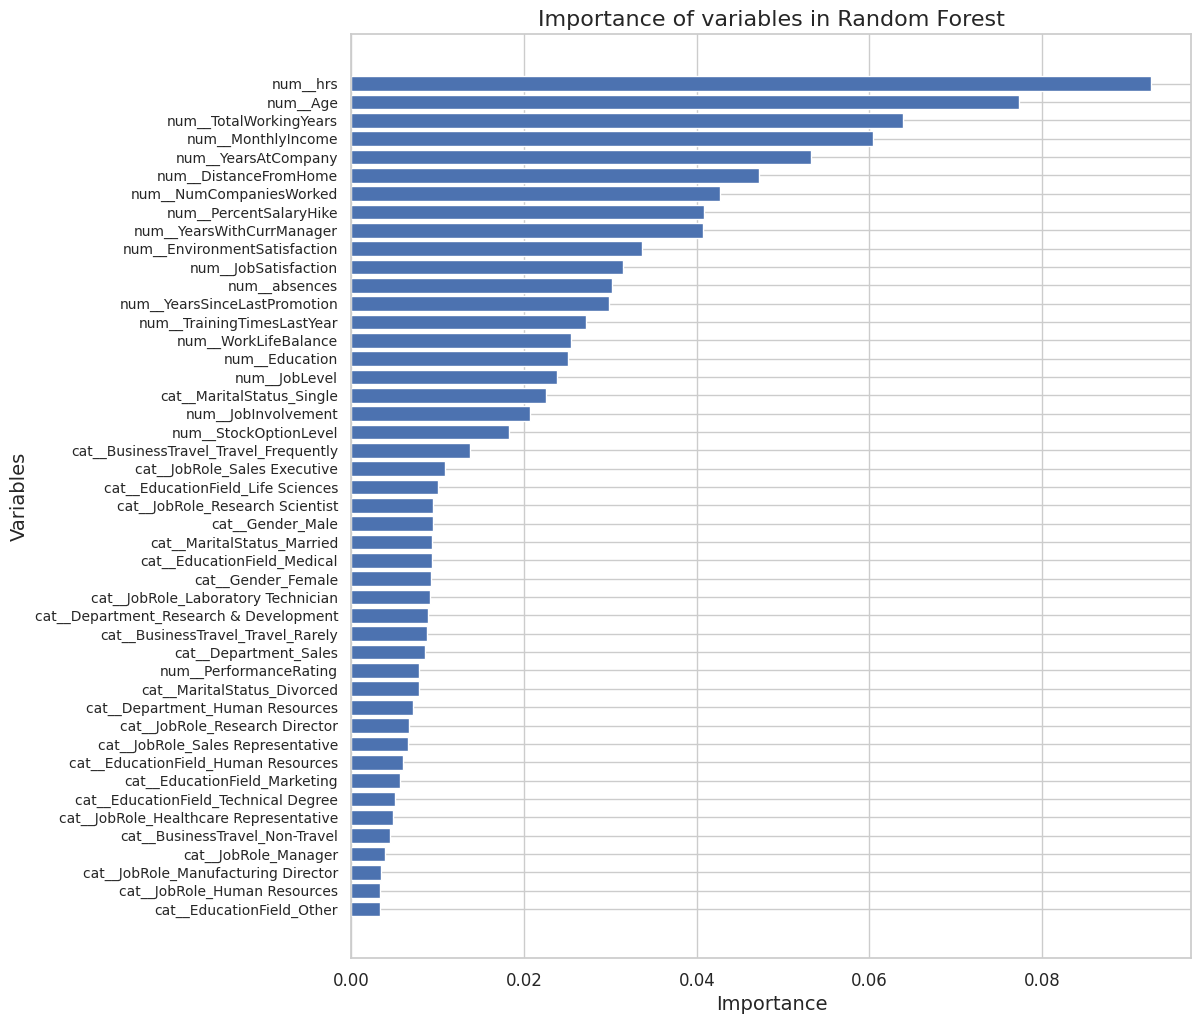

In [ ]:
best_rf = grid_search_random_forest.best_estimator_

rf_model = best_rf.named_steps['classifier']

preprocessor = best_rf.named_steps['preprocessor']

if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)
else:
    feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]

importances = rf_model.feature_importances_

if len(feature_names) != len(importances):
    raise ValueError("No Match")

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(14, 12))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Variables', fontsize=14)
plt.title('Importance of variables in Random Forest', fontsize=16)
plt.gca().invert_yaxis()

plt.subplots_adjust(left=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

plt.show()

The variable importance plot from the Random Forest model highlights the most influential features contributing to predictions. The top variables, such as `num__hrs`, `num__Age`, and `num__TotalWorkingYears`, have the highest importance scores, indicating their strong impact on the model's outcomes. These features likely capture key patterns or relationships with the target variable. In contrast, lower-ranked variables contribute less to the predictive performance, suggesting they provide limited additional information.

## **Xgboost**

For the boosting technique, we chose XGBoost due to its efficiency, scalability, and exceptional performance with structured data. XGBoost (Extreme Gradient Boosting) builds models iteratively by focusing on the errors of the previous models, improving predictive power through weighted adjustments. It includes built-in regularization mechanisms that help prevent overfitting, which is especially useful when working with complex or noisy datasets. Furthermore, XGBoost allows us to fine-tune hyperparameters such as learning rate, maximum tree depth, and subsampling, which can significantly enhance model performance. Its ability to handle class imbalance through evaluation metrics like balanced accuracy further strengthens its effectiveness for this task.

In [ ]:
# Pipeline for SMOTE and XGBoost
def create_pipeline_xgboost(params):
    return ImbPipeline([
        ('preprocessor', preprocessor_knn),
        ('smote', SMOTE(random_state=1470)),
        ('classifier', XGBClassifier(
            max_depth=params.get('max_depth', 6),
            learning_rate=params.get('learning_rate', 0.1),
            n_estimators=params.get('n_estimators', 100),
            subsample=params.get('subsample', 1.0),
            colsample_bytree=params.get('colsample_bytree', 1.0),
            random_state=1470,
            use_label_encoder=False,
            eval_metric='logloss'
        ))
    ])

# HPO for GridSearchCV for XGBoost
param_grid_xgboost = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}


grid_search_xgboost = GridSearchCV(
    estimator=create_pipeline_xgboost({}),
    param_grid=param_grid_xgboost,
    scoring='balanced_accuracy',
    cv=inner,
    refit=True,
    n_jobs=-1,
    return_train_score=True
)

start_xgboost= time()
grid_search_xgboost.fit(X_train, y_train)
end_xgboost = time()


In [ ]:
xgboost_grid_results = pd.DataFrame(grid_search_xgboost.cv_results_)

xgboost_grid_best_balanced_accuracy = grid_search_xgboost.best_score_
xgboost_grid_execution_time = round(end_xgboost - start_xgboost, 3)

print(f"Total Execution Time: {xgboost_grid_execution_time} seconds")

xgboost_grid_results = pd.concat([
    xgboost_grid_results['params'].apply(pd.Series),
    xgboost_grid_results[['mean_test_score', 'std_test_score', 'rank_test_score']]
], axis=1)


xgboost_grid_results.columns = [
    'Max Depth', 'Learning Rate', 'N Estimators', 'Subsample', 'Colsample Bytree',
    'Mean Balanced Accuracy', 'Std Balanced Accuracy', 'Rank'
]

xgboost_grid_results = xgboost_grid_results.sort_values(by='Rank').reset_index(drop=True)

xgboost_grid_results.head(10)


Total Execution Time: 527.787 seconds


,Max Depth,Learning Rate,N Estimators,Subsample,Colsample Bytree,Mean Balanced Accuracy,Std Balanced Accuracy,Rank
0,0.8,0.2,7.0,200.0,1.0,0.878505,0.028172,1
1,0.8,0.1,7.0,300.0,0.8,0.877140,0.025578,2
2,0.8,0.2,7.0,300.0,1.0,0.876936,0.029566,3
3,0.8,0.1,7.0,200.0,0.8,0.875570,0.032875,4
4,0.8,0.2,5.0,200.0,0.8,0.874862,0.018537,5
5,1.0,0.1,7.0,200.0,1.0,0.874559,0.024627,6
6,1.0,0.1,7.0,300.0,1.0,0.873799,0.024377,7
7,1.0,0.2,7.0,300.0,1.0,0.873543,0.028677,8
8,0.8,0.2,7.0,100.0,1.0,0.872988,0.029486,9
9,1.0,0.2,7.0,200.0,1.0,0.872481,0.027917,10


The **XGBoost model with SMOTE and Grid Search** demonstrates exceptional performance in handling **class imbalance** while achieving high **Balanced Accuracy scores**. The **best-performing configuration** achieved a **Balanced Accuracy of 0.8785**, with the following hyperparameters: **`Max Depth=7`**, **`Learning Rate=0.2`**, **`N Estimators=200`**, **`Subsample=0.8`**, and **`Colsample Bytree=1.0`**. These hyperparameters suggest a moderately deep tree structure, an optimal learning rate, and robust sampling strategies, all contributing to a well-generalized model.

The **top-ranked trials** exhibit slight variations in hyperparameters, yet consistently achieve **Balanced Accuracy values above 0.87**, highlighting the stability of XGBoost under different configurations. The use of **SMOTE** effectively balanced the dataset, enabling the model to better represent the minority class during training.

The **execution time of 527 seconds** reflects the computational intensity of tuning XGBoost due to its extensive hyperparameter space and iterative boosting nature. Despite this, the results justify the computational cost, as the model outperforms other techniques explored earlier.

In summary, **XGBoost with SMOTE and Grid Search emerges as one of the most accurate models**, offering both strong predictive performance and flexibility in capturing complex patterns within imbalanced datasets. This configuration is particularly suitable for scenarios where high accuracy is prioritized over computational efficiency.

## Summary of Basic and Advanced Methods

In [ ]:
new_results = [
    {'Model': 'XGBoost', 'Balanced Accuracy': xgboost_grid_best_balanced_accuracy, 'Execution Time (s)': xgboost_grid_execution_time},
    {'Model': 'Random Forest', 'Balanced Accuracy': rf_grid_best_balanced_accuracy, 'Execution Time (s)': rf_grid_execution_time}
]


results_df = pd.concat([results_df, pd.DataFrame(new_results)], ignore_index=True)

results_df = results_df.sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)
results_df

,Model,Balanced Accuracy,Execution Time (s)
0,XGBoost,0.878505,527.787
1,XGBoost,0.878505,527.787
2,KNN SMOTE Grid Search,0.863296,12.824
3,KNN SMOTE Optuna,0.863296,36.844
4,KNN Grid Search,0.846784,16.029
5,KNN Optuna,0.846784,32.299
6,Random Forest,0.826227,344.212
7,Random Forest,0.826227,344.212
8,Decision Tree,0.825082,0.413
9,Decision Tree SMOTE Grid Search,0.814207,96.134


After evaluating various models, **XGBoost emerged as the top-performing model with a Balanced Accuracy of 0.8785**, demonstrating its superior ability to handle complex patterns in imbalanced data. However, its performance comes at a high computational cost, with an execution time of **527 seconds**. **KNN models optimized via Optuna (0.8632)** and **Grid Search (0.863)** delivered competitive results with significantly lower execution times, making them efficient alternatives when resources are limited. **Random Forest (0.826)** and **Decision Tree (0.825)** models showed reliable performance, with Random Forest being more computationally intensive but offering robust generalization. Decision Trees, while less computationally demanding, benefit from interpretability but showed limited improvement with hyperparameter optimization. Handling class imbalance through **SMOTE and Class Weights** consistently improved results across models. In conclusion, **XGBoost is recommended for maximum performance**, while **KNN Optuna or Grid Search** offers a balanced trade-off between accuracy and computational efficiency.

#**6. Results and final model**

The final model selected after the grid search was XGBoost, which demonstrated the best performance across all evaluated metrics. The model was trained using the optimized hyperparameters and fitted with the training dataset `(X_train, y_train)`.

The XGBoost model was chosen as the final model due to its robust performance and consistent results across both training and test datasets.



In [ ]:
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
# final model with best hp
best_pipeline = grid_search_xgboost.best_estimator_
best_pipeline.fit(X_train, y_train)

# final metrics in the test
predicciones = best_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predicciones)
balanced_accuracy = balanced_accuracy_score(y_test, predicciones)
test_confusion_matrix = confusion_matrix(y_test, predicciones)

print(f"Accuracy in the testing set: {100 * accuracy:.2f} %")
print(f"Balanced accuracy in the testing set: {100 * balanced_accuracy:.2f} %")

Accuracy in the testing set: 96.94 %
Balanced accuracy in the testing set: 92.23 %


## Predictions with best method


After selecting XGBoost as the final model, it was retrained using the entire dataset (`X, y`) to maximize predictive performance. The competition dataset (`competition_data.csv`) was then loaded and preprocessed using the final pipeline. The preprocessing steps included:

1. Excluding irrelevant or target columns.
2. Transforming features using the preprocessing pipeline.
3. Ensuring the processed dataset matched the required format for the classifier.

The final predictions were generated and, if necessary, decoded into their original labels.

The results were saved in a CSV file named `competition_results.csv`, containing:

- **ID**: Index of the competition dataset.
- **Attrition_Prediction**: Predicted outcomes for each instance.

In [ ]:
import joblib

final_model = grid_search_xgboost.best_estimator_

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
final_model.fit(X, y)

competition_data = pd.read_csv('attrition_competition_07.csv')

X_competition = competition_data.copy()

X_competition_processed = final_model.named_steps['preprocessor'].transform(X_competition)

X_competition_processed = pd.DataFrame(
    X_competition_processed,
    columns=final_model.named_steps['preprocessor'].get_feature_names_out()
)

competition_predictions = final_model.named_steps['classifier'].predict(X_competition_processed)

competition_predictions = label_encoder.inverse_transform(competition_predictions)


competition_results = pd.DataFrame({
    'ID': competition_data.index,
    'Attrition_Prediction': competition_predictions
})

competition_results.to_csv('competition_predictions.csv', index=False)
print("Predictions saved in 'competition_predictions.csv'")

# Save the final model
joblib.dump(final_model, 'final_model_xgboost.pkl')
print("Final model saved in 'final_model_xgboost.pkl'")


Predictions saved in 'competition_predictions.csv'
Final model saved in 'final_model_xgboost.pkl'


# **7. Open Choice Task**

In this section, we decided to incorporate **SHAP (SHapley Additive exPlanations)** to enhance the interpretability of our trained model. The rationale behind this choice is that while achieving high predictive performance is essential, understanding the factors driving the predictions is equally important, especially in scenarios where decision-making impacts stakeholders.



## **SHAP**

SHAP values provide a consistent and interpretable way to explain the contribution of each feature to a model's prediction. Unlike traditional feature importance scores, SHAP values consider the impact of each feature across all possible combinations of features, ensuring a fair representation of its contribution.



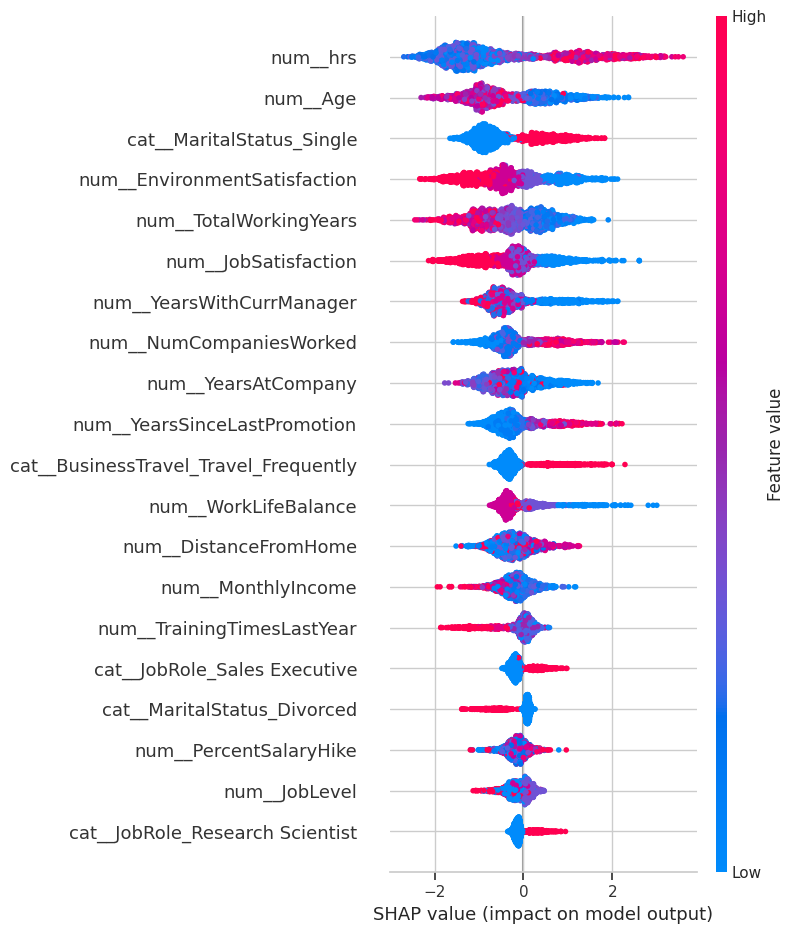

In [ ]:
import shap

final_model = best_pipeline.named_steps['classifier']

X_train_processed = best_pipeline.named_steps['preprocessor'].transform(X_train)
X_train_processed = pd.DataFrame(
    X_train_processed,
    columns=best_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

explainer = shap.TreeExplainer(final_model, feature_perturbation="tree_path_dependent")

shap_values = explainer.shap_values(X_train_processed)

shap.summary_plot(shap_values, X_train_processed)


The image displays a SHAP (SHapley Additive exPlanations) summary plot, which provides a global interpretation of the model's predictions by showing the impact of each feature on the model's output. This visualization helps identify which features most influence predictions, whether their contributions are positive or negative, and how their values correspond to their impact.

On the y-axis, the features are ordered by their overall importance, with the most influential feature at the top (`num__hrs`) and the least at the bottom (`cat__JobRole_Research Scientist`). Each dot represents a SHAP value for a feature in a single prediction, showing how much that feature pushed the prediction higher or lower.

The x-axis represents the SHAP value, indicating the direction and magnitude of each feature's impact on the model's prediction. Positive SHAP values push predictions toward a positive class, while negative values push them toward the negative class.

The color gradient, ranging from blue to red, represents the feature value: blue indicates low feature values, and red indicates high values.

- Features like `num__EnvironmentSatisfaction`, `num__JobSatisfaction`, and `num__WorkLifeBalance` show a mix of positive and negative impacts depending on their value.
- Categorical features like `cat__MaritalStatus_Single` and `cat__BusinessTravel_Travel_Frequently` highlight clear patterns where specific categories strongly affect predictions.

The plot reveals that both numerical and categorical features contribute significantly to the model's predictions. Some features, like `num__hrs` and `num__Age`, have a consistently strong influence, while others, like `num__TrainingTimesLastYear` and `cat__JobRole_Research Scientist`, have more modest but still relevant impacts.

# **Extra group of 3 - Calibration**

In this section, we aim to evaluate whether our **Random Forest model** provides well-calibrated probability predictions. A calibrated model ensures that the predicted probabilities accurately reflect the likelihood of an event occurring. For instance, if the model predicts a probability of 0.8 for a class, approximately 80% of those predictions should correspond to the actual class.

Objectives:
1. **Evaluate Calibration:**

  - We will generate a calibration curve to compare the predicted probabilities with the actual observed frequencies.
  - A well-calibrated model's curve should follow a diagonal line, indicating a consistent relationship between predicted probabilities and observed outcomes.
2. **Adjust Calibration if Necessary:**

  - If the calibration curve shows significant deviations from the diagonal, we will apply Sigmoid Calibration to adjust the probability predictions.
  - This adjustment ensures more reliable outputs, especially when probabilities are used for decision-making.


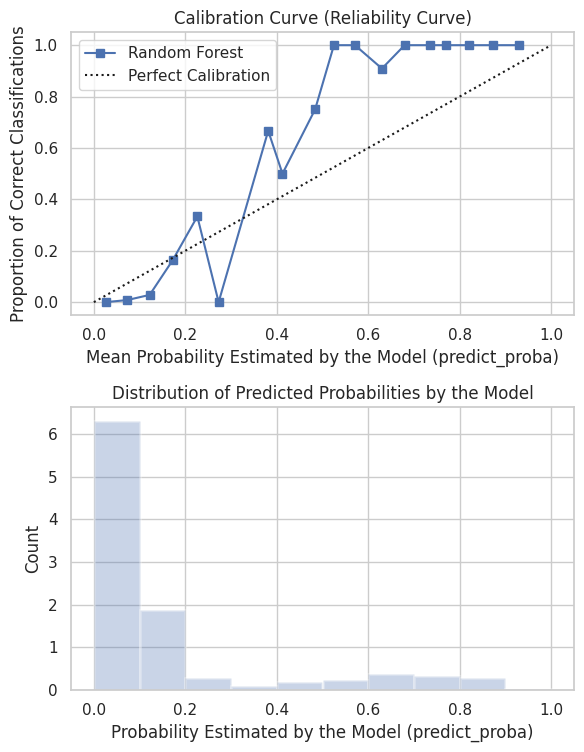

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

best_rf.fit(X_train, y_train)
pred = best_rf.predict_proba(X=X_test)
prob_pos = pred[:, 1]

# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the labels
y_test_encoded = le.fit_transform(y_test)

# Calibrate the existing model
frac_pos, media_prob_pred = calibration_curve(y_test_encoded, prob_pos, n_bins=20)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 2*3.84))

# Plot the calibration curve
axs[0].plot(media_prob_pred, frac_pos, "s-", label="Random Forest")
axs[0].plot([0, 1], [0, 1], "k:", label="Perfect Calibration")
axs[0].set_ylabel("Proportion of Correct Classifications")
axs[0].set_xlabel("Mean Probability Estimated by the Model (predict_proba)")
axs[0].set_title('Calibration Curve (Reliability Curve)')
axs[0].legend()

# Plot the predicted probability distribution
axs[1].hist(prob_pos, range=(0, 1), bins=10, density=True, lw=2, alpha=0.3)
axs[1].set_xlabel("Probability Estimated by the Model (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribution of Predicted Probabilities by the Model')

plt.tight_layout()
plt.show()


- The model struggles with **probability calibration** in the lower ranges, often underestimating or misrepresenting probabilities.
- For higher probabilities, there is better alignment, but deviations still exist.
- The distribution of predicted probabilities is heavily skewed towards low probability bins, limiting the model's expressiveness in predicting high-confidence positive outcomes.

**Sigmoid Calibration**

The poor alignment suggests the need for Sigmoid Calibration to adjust the predicted probabilities and improve reliability across all probability ranges.


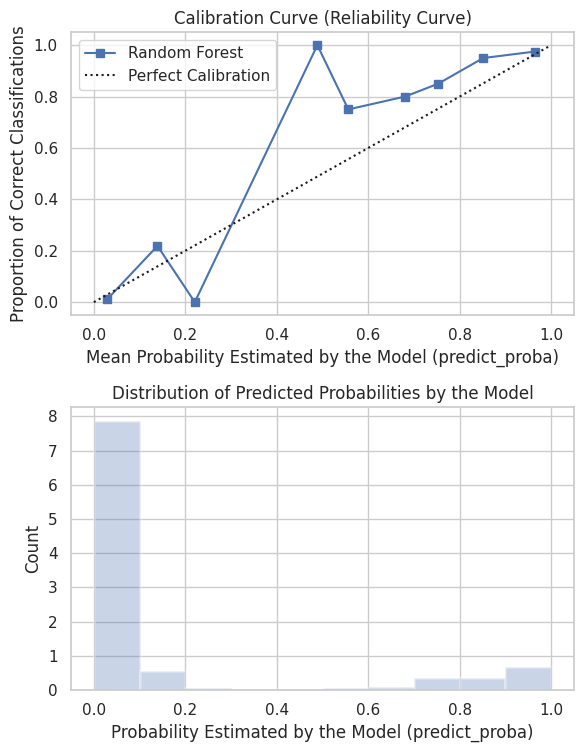

In [ ]:
# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the labels
y_test_encoded = le.fit_transform(y_test)

# Calibrate the existing model
X_train_preprocessed = best_rf.named_steps['preprocessor'].transform(X_train)
rf_calibrated = CalibratedClassifierCV(best_rf.named_steps['classifier'], method='sigmoid', cv=5)
rf_calibrated.fit(X_train_preprocessed, y_train)

# Calibration curve
X_test_preprocessed = best_rf.named_steps['preprocessor'].transform(X_test)

prob_true, prob_pred = calibration_curve(y_test_encoded, rf_calibrated.predict_proba(X_test_preprocessed)[:, 1], n_bins=10)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 2*3.84))

# Plot the calibration curve
axs[0].plot(prob_pred, prob_true, "s-", label="Random Forest")
axs[0].plot([0, 1], [0, 1], "k:", label="Perfect Calibration")
axs[0].set_ylabel("Proportion of Correct Classifications")
axs[0].set_xlabel("Mean Probability Estimated by the Model (predict_proba)")
axs[0].set_title('Calibration Curve (Reliability Curve)')
axs[0].legend()

# Plot the predicted probability distribution
axs[1].hist(rf_calibrated.predict_proba(X_test_preprocessed)[:, 1], range=(0, 1), bins=10, density=True, lw=2, alpha=0.3)
axs[1].set_xlabel("Probability Estimated by the Model (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribution of Predicted Probabilities by the Model')

plt.tight_layout()
plt.show()


The application of **Sigmoid Calibration** effectively addressed the initial misalignment in the probability predictions of the Random Forest model. The calibration curve closely follows the diagonal, demonstrating improved reliability across all probability ranges. This adjustment enhances the model's trustworthiness, especially in scenarios where probability scores are critical for decision-making.










**Isotonic Calibration**

After applying **Isotonic Calibration** to the Random Forest model, we observe improvements in the alignment between predicted probabilities and observed outcomes, though with some distinct characteristics compared to Sigmoid Calibration.



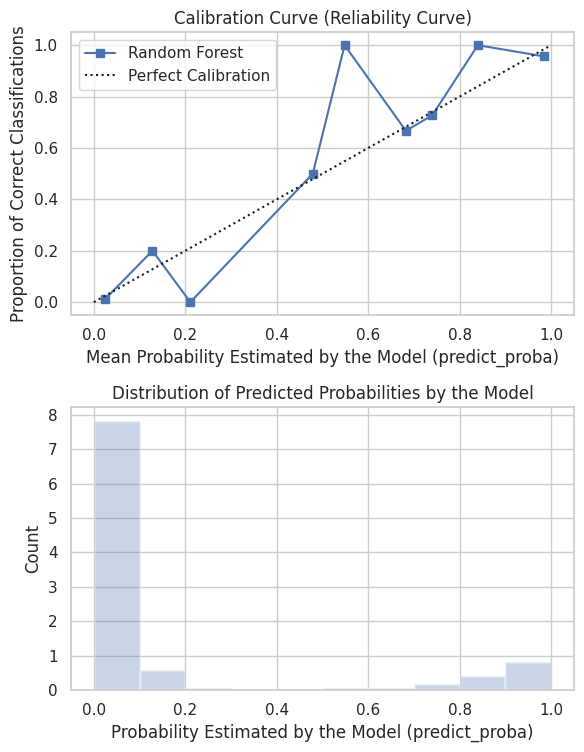

In [ ]:
# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the labels
y_test_encoded = le.fit_transform(y_test)

# Calibrate the existing model
X_train_preprocessed = best_rf.named_steps['preprocessor'].transform(X_train)
rf_calibrated = CalibratedClassifierCV(best_rf.named_steps['classifier'], method='isotonic', cv=5)
rf_calibrated.fit(X_train_preprocessed, y_train)

# Calibration curve
X_test_preprocessed = best_rf.named_steps['preprocessor'].transform(X_test)

prob_true, prob_pred = calibration_curve(y_test_encoded, rf_calibrated.predict_proba(X_test_preprocessed)[:, 1], n_bins=10)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 2*3.84))

# Plot the calibration curve
axs[0].plot(prob_pred, prob_true, "s-", label="Random Forest")
axs[0].plot([0, 1], [0, 1], "k:", label="Perfect Calibration")
axs[0].set_ylabel("Proportion of Correct Classifications")
axs[0].set_xlabel("Mean Probability Estimated by the Model (predict_proba)")
axs[0].set_title('Calibration Curve (Reliability Curve)')
axs[0].legend()

# Plot the predicted probability distribution
axs[1].hist(rf_calibrated.predict_proba(X_test_preprocessed)[:, 1], range=(0, 1), bins=10, density=True, lw=2, alpha=0.3)
axs[1].set_xlabel("Probability Estimated by the Model (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribution of Predicted Probabilities by the Model')

plt.tight_layout()
plt.show()


**Comparison with Sigmoid Calibration**
- **Sigmoid Calibration** tends to provide smoother adjustments across all probability ranges.
- **Isotonic Calibration**, being a non-parametric approach, adapts more flexibly to the data but shows occasional overfitting in specific bins (the sharp jump around 0.4).

**Final Conclusions For Calibration**

In this additional calibration analysis, we evaluated the **Random Forest model's probability predictions** using both S**igmoid Calibration** and **Isotonic Calibration** to improve their reliability.

Initially, the uncalibrated model showed significant deviations from the ideal calibration line, particularly in the lower **probability ranges (0.0–0.4)**, indicating poor representation of predicted probabilities. After applying both calibration techniques, we observed distinct improvements:

- **Sigmoid Calibration:** Provided a smoother adjustment across all probability ranges. The calibration curve aligned more closely with the diagonal, demonstrating a balanced improvement in both low and high probability regions. It is computationally efficient and generally performs well when the relationship between predicted and true probabilities is logistic in nature.

- **Isotonic Calibration:** Offered a more flexible and localized adjustment, particularly excelling in higher probability ranges. However, it exhibited some irregularities in specific probability bins, suggesting potential overfitting to the calibration data.